<a href="https://colab.research.google.com/github/YilmazTrigumariS/Gudang-Garam-Stock-Forecasting/blob/main/notebook/GGRM_Stock_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GUDANG GARAM (GGRM) Stock Forecasting Business Plan**

---

## **Introduction**

### **Company Background**  
Clove Investments Indonesia is a trusted mutual fund investment company dedicated to providing tailored financial solutions for a diverse range of investors. With a strong focus on growth, stability, and expert management, the company delivers personalized guidance through a skilled team of financial advisors to achieve clients' unique investment goals.

---

## **Stakeholders**

1. **Mutual Fund Manager:** Seeking innovative tools to enhance trading strategies for "GGRM" stock.
2. **Investors:** Expecting maximized returns with robust risk management and clear performance insights.

---

## **Problem Statement**

How can we develop a machine learning model capable of forecasting "GGRM" stock prices for the next year to:  
- Enhance the mutual fund manager's ability to execute long and short strategies.  
- Maximize returns through bi-directional trading.  
- Maintain robust risk management.

---

## **Goals**

- Minimize investment risk.  
- Enhance investor confidence.  
- Maximize returns by capitalizing on price movements.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import warnings
warnings.filterwarnings("ignore")

# Forecasting
import prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

import math
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Dropout, BatchNormalization

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

`LSTM Model`

In [6]:
df = pd.read_csv('cast.csv', parse_dates= True , index_col= "ds")
df.drop(columns = ['Unnamed: 0'], inplace = True)
df

,y
ds,
2021-02-05,32318.501953
2021-02-06,32318.501953
2021-02-07,32318.501953
2021-02-08,32256.154297
2021-02-09,32235.369141
...,...
2025-01-31,11250.000000
2025-02-01,11250.000000
2025-02-02,11250.000000


In [7]:
dataset = df["y"]
dataset = pd.DataFrame(dataset)

data = dataset.values

data.shape

(1461, 1)

In [8]:
df.describe()

,y
count,1461.000000
mean,23648.797527
std,5481.573748
min,10875.000000
25%,19750.000000
50%,24589.648438
75%,27864.843750
max,39281.007812


### **Descriptive Statistics:**  
- **Average Price:** Rp 23,648  
- **Min Price:** Rp 10,875  
- **Median:** Rp 24,589  
- **Max Price:** Rp 39,281  

---

## **Data Preparation and Analysis**  

- **Training Data:** February 5, 2021 – December 31, 2023  
- **Validation Data:** January 1, 2024 – February 4, 2025

---

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data).reshape(-1, 1))

In [10]:
train_size = int(len(data)*.75)
test_size = len(data) - train_size

print("Train Size :",train_size,"Test Size :",test_size)

train_data = scaled_data[ :train_size , 0:1 ]
test_data = scaled_data[ train_size-60: , 0:1 ]

Train Size : 1095 Test Size : 366


In [11]:
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [12]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [13]:
# Reshaping the input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [14]:
model = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train.shape[1], 1)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          29,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,465 (165.88 KB)

 Trainable params: 42,465 (165.88 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Fitting the LSTM to the Training set
callbacks = [EarlyStopping(monitor= 'loss', patience= 10 , restore_best_weights= True)]
history = model.fit(x_train, y_train, epochs= 100, batch_size= 32 , callbacks= callbacks )

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 0.0782 - mean_absolute_error: 0.2074
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0034 - mean_absolute_error: 0.0452
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0020 - mean_absolute_error: 0.0327
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0014 - mean_absolute_error: 0.0259
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0014 - mean_absolute_error: 0.0252
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0013 - mean_absolute_error: 0.0252
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0011 - mean_absolute_error: 0.0221
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0011 - mean_absolute_error: 0.0225
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0010 - mean_absolute_error: 0.0215
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0010 - mean_absolute_error: 0.0214
Epoch 11/100
33/33 ━━━━━━━━━━

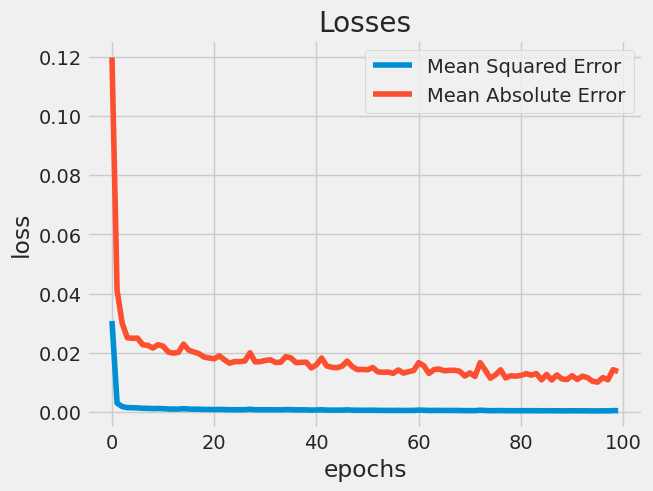

In [17]:
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Insight
* Both Mean Squared Error (MSE) and Mean Absolute Error (MAE) are decreasing over epochs, indicating that the model is learning effectively.
* MSE remains consistently low, showing stable training without excessive fluctuations.
* MAE shows a sharp decline initially, then fluctuates slightly around a lower bound, suggesting that the model's performance has improved but might need fine-tuning.

In [18]:
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [19]:
#inverse y_test scaling
predictions = model.predict(x_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


(366, 1)

In [20]:
y_test = scaler.inverse_transform([y_test])

RMSE = np.sqrt(np.mean(y_test - predictions )**2).round(2)
RMSE

142.26

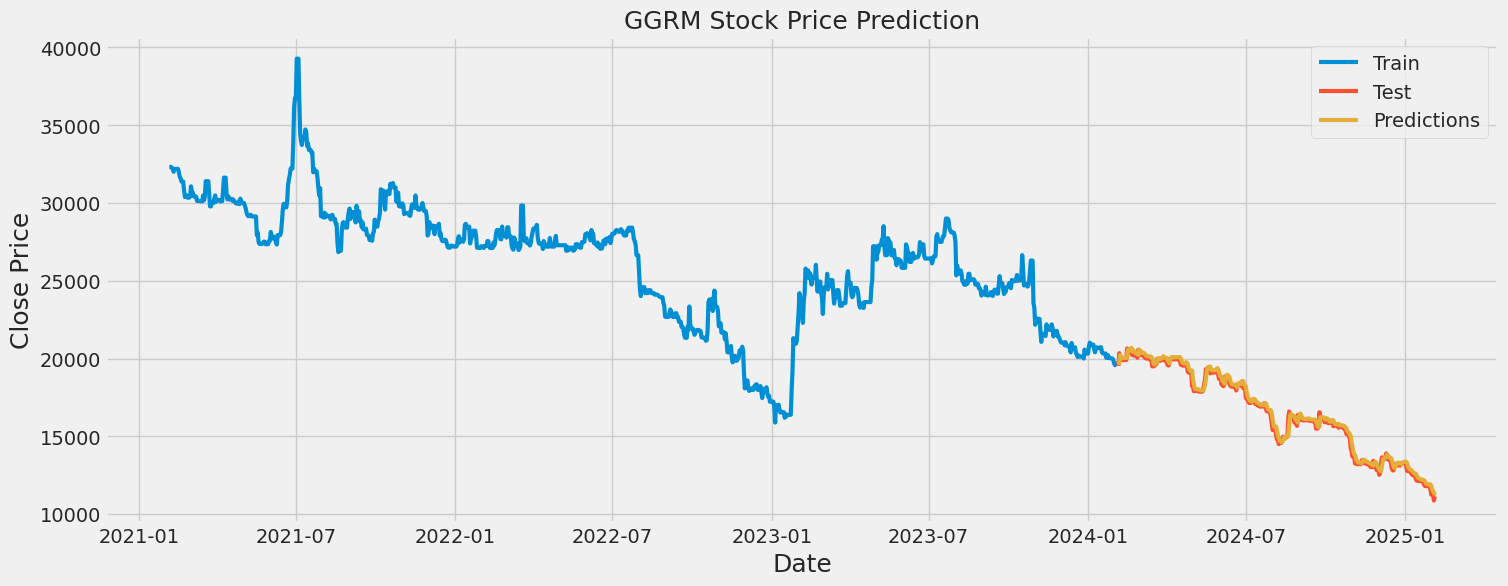

In [21]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('GGRM Stock Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price', fontsize= 18)
plt.plot(train['y'], linewidth= 3)
plt.plot(test['y'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])

Insight:

1. Downward Trend Since Mid-2022

* The stock price was relatively stable from 2021 to mid-2022, with a peak around 40,000.
* After mid-2022, a strong bearish trend emerged, causing significant declines.
* The drop accelerated further post-2023, signaling possible economic or company-related weaknesses.

2. Prediction Captures the Downtrend

* The orange (test data) trend follows the actual movement closely, confirming that the LSTM model is capturing the pattern.
* The predicted trend continues downward, indicating that based on past trends, the model expects further decline.

In [22]:
from datetime import timedelta

In [23]:
def insert_end(Xin, new_input):
    timestep = 60
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin

In [24]:
future = 30
forcast = []
Xin = x_test[-1 :, :, :]
time = []
for i in range(0, future):
    out = model.predict(Xin, batch_size=5)
    forcast.append(out[0, 0])
    print(forcast)
    Xin = insert_end(Xin, out[0, 0])
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[0.0124513665]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[0.0124513665, 0.012936425]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[0.0124513665, 0.012936425, 0.014811736]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[0.0124513665, 0.012936425, 0.014811736, 0.0169124]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[0.0124513665, 0.012936425, 0.014811736, 0.0169124, 0.019009642]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[0.0124513665, 0.012936425, 0.014811736, 0.0169124, 0.019009642, 0.021061331]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[0.0124513665, 0.012936425, 0.014811736, 0.0169124, 0.019009642, 0.021061331, 0.023072336]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[0.0124513665, 0.012936425, 0.014811736, 0.0169124, 0.019009642, 0.021061331, 0.023072336, 0.025060067]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[0.0124513665, 0.012936425, 0.014811736, 0.0169124, 0.019009642, 0.021061331, 0.023072336, 0.025060067, 0.027042704]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[0.0124513665, 0.012936425, 0

In [25]:
forcasted_output = np.asanyarray(forcast)
forcasted_output = forcasted_output.reshape(-1, 1)
forcasted_output = scaler.inverse_transform(forcasted_output)

In [26]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output], axis=1)
df_result.columns = "Date", "Forecasted"

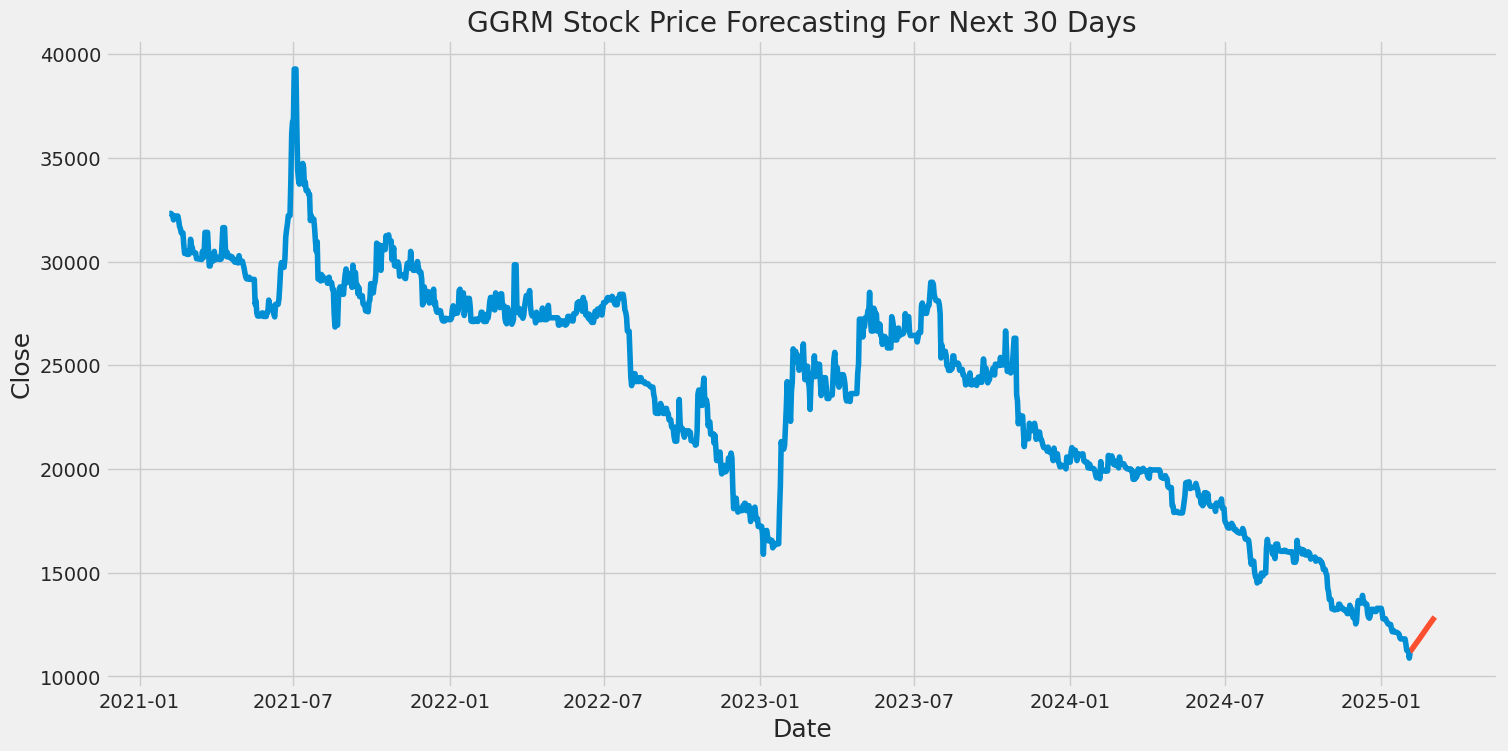

In [27]:
plt.figure(figsize=(16, 8))
plt.title('GGRM Stock Price Forecasting For Next 30 Days')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close' ,fontsize=18)
plt.plot(df['y'])
plt.plot(df_result.set_index('Date')[['Forecasted']])

Insight:

1. Historical Stock Performance (2021-2024)
* GGRM's stock price has been in a consistent downward trend since mid-2022.
* The stock peaked at ~40,000 in 2021, followed by steady declines.
* The bearish trend intensified in 2023 and continued into early 2025 with no signs of recovery.

2. Forecast for the Next 30 Days (Red Line)
* The model predicts a sudden upward jump in prices.
* Given the previous long-term downtrend, this spike seems unexpected and may not align with actual market conditions.
* This indicates the LSTM model may have struggled to capture the long-term bearish trend.

In [28]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
from itertools import product
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('cast.csv').drop(columns=['Unnamed: 0'])
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')

# Generate synthetic regressors
np.random.seed(42)
df['holiday_index'] = np.random.uniform(0, 1, len(df))
df['macro_factor'] = np.random.uniform(0, 1, len(df))

# Train-test split
df_train = df[(df['ds'] >= '2021-02-05') & (df['ds'] <= '2023-12-31')]
df_test = df[(df['ds'] >= '2024-01-01') & (df['ds'] <= '2025-02-04')]

# Enhanced parameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'n_changepoints': [25, 30, 35],
    'changepoint_range': [0.85, 0.9],
    'yearly_fourier_order': [8, 12]  # New parameter for custom seasonality
}

# Performance metric calculation
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

best_mae = float("inf")
best_params = None
best_model = None

# Grid search implementation
for params in product(*param_grid.values()):
    try:
        # Unpack parameters
        (cps, sps, smode, ncp, crange, yfourier) = params

        # Initialize model with current parameters
        model = Prophet(
            changepoint_prior_scale=cps,
            seasonality_prior_scale=sps,
            seasonality_mode=smode,
            n_changepoints=ncp,
            changepoint_range=crange,
            yearly_seasonality=False  # Disable default yearly seasonality
        )

        # Add custom seasonality with specified Fourier order
        model.add_seasonality(
            name='yearly',
            period=365.25,
            fourier_order=yfourier
        )

        # Add regressors
        model.add_regressor('holiday_index')
        model.add_regressor('macro_factor')

        # Fit model
        model.fit(df_train)

        # Create future dataframe
        future = model.make_future_dataframe(periods=len(df_test), include_history=False)
        future['holiday_index'] = df_test['holiday_index'].values
        future['macro_factor'] = df_test['macro_factor'].values

        # Generate predictions
        forecast = model.predict(future)
        results = pd.merge(df_test, forecast[['ds', 'yhat']], on='ds')

        # Calculate metrics
        mae = mean_absolute_error(results['y'], results['yhat'])
        mape = mean_absolute_percentage_error(results['y'], results['yhat'])

        print(f"Params: {params} | MAE: {mae:.2f}, MAPE: {mape:.2f}%")

        if mae < best_mae:
            best_mae = mae
            best_mape = mape
            best_params = params
            best_model = model

    except Exception as e:
        print(f"Error with params {params}: {str(e)}")
        continue

print(f"\nBest Params: {best_params}")
print(f"Best MAE: {best_mae:.2f}, MAPE: {best_mape:.2f}%")

# Final model training and forecasting
full_model = Prophet(
    changepoint_prior_scale=best_params[0],
    seasonality_prior_scale=best_params[1],
    seasonality_mode=best_params[2],
    n_changepoints=best_params[3],
    changepoint_range=best_params[4],
    yearly_seasonality=False
).add_seasonality(
    name='yearly',
    period=365.25,
    fourier_order=best_params[5]
).add_regressor('holiday_index').add_regressor('macro_factor')

full_model.fit(df)

# Create 1-year future dataframe
future = full_model.make_future_dataframe(periods=365, freq='D')
future['holiday_index'] = np.random.uniform(0, 1, len(future))  # Replace with actual data
future['macro_factor'] = np.random.uniform(0, 1, len(future))   # Replace with actual data

# Generate forecast
forecast = full_model.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/3485ms_v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/o1qprtkk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17674', 'data', 'file=/tmp/tmp8fhej9qx/3485ms_v.json', 'init=/tmp/tmp8fhej9qx/o1qprtkk.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelliki6t04/prophet_model-20250304075555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:55:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:55:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8f

Params: (0.001, 0.01, 'additive', 25, 0.85, 8) | MAE: 3701.91, MAPE: 23.60%


07:55:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/h0eupmsy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/1z4trnw4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1073', 'data', 'file=/tmp/tmp8fhej9qx/h0eupmsy.json', 'init=/tmp/tmp8fhej9qx/1z4trnw4.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelds7gfp4i/prophet_model-20250304075556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:55:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:55:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.01, 'additive', 25, 0.85, 12) | MAE: 3597.24, MAPE: 22.93%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/9hzwezpz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/24qn5x09.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68892', 'data', 'file=/tmp/tmp8fhej9qx/9hzwezpz.json', 'init=/tmp/tmp8fhej9qx/24qn5x09.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelrxsxhwnt/prophet_model-20250304075556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:55:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 0.01, 'additive', 25, 0.9, 8) | MAE: 3857.75, MAPE: 24.64%


07:55:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/7fg0h6c_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/h3kjbnjq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85635', 'data', 'file=/tmp/tmp8fhej9qx/7fg0h6c_.json', 'init=/tmp/tmp8fhej9qx/h3kjbnjq.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelhxxjx7p8/prophet_model-20250304075556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:55:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:55:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.01, 'additive', 25, 0.9, 12) | MAE: 3711.01, MAPE: 23.65%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/yytmnlvj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/u_wrucmy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89212', 'data', 'file=/tmp/tmp8fhej9qx/yytmnlvj.json', 'init=/tmp/tmp8fhej9qx/u_wrucmy.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelk2l3us5x/prophet_model-20250304075557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:55:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:55:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.01, 'additive', 30, 0.85, 8) | MAE: 3648.46, MAPE: 23.25%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/__nmj1ap.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/v7r9kx0k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70380', 'data', 'file=/tmp/tmp8fhej9qx/__nmj1ap.json', 'init=/tmp/tmp8fhej9qx/v7r9kx0k.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelcs757usq/prophet_model-20250304075557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:55:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:55:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.01, 'additive', 30, 0.85, 12) | MAE: 3635.50, MAPE: 23.17%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/2bgu4d1s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/p0dhlesc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20625', 'data', 'file=/tmp/tmp8fhej9qx/2bgu4d1s.json', 'init=/tmp/tmp8fhej9qx/p0dhlesc.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelcg692wt1/prophet_model-20250304075557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:55:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:55:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.01, 'additive', 30, 0.9, 8) | MAE: 3692.81, MAPE: 23.60%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/kxgfoz4h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/7blp0zzk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50887', 'data', 'file=/tmp/tmp8fhej9qx/kxgfoz4h.json', 'init=/tmp/tmp8fhej9qx/7blp0zzk.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model_55bev_5/prophet_model-20250304075558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:55:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:55:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.01, 'additive', 30, 0.9, 12) | MAE: 3610.59, MAPE: 23.01%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/yt1t_yso.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/9grmowhb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2098', 'data', 'file=/tmp/tmp8fhej9qx/yt1t_yso.json', 'init=/tmp/tmp8fhej9qx/9grmowhb.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model45vjqkw2/prophet_model-20250304075558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:55:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:55:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.01, 'additive', 35, 0.85, 8) | MAE: 3842.41, MAPE: 24.52%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/wowv3kws.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/4xot1c8x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48293', 'data', 'file=/tmp/tmp8fhej9qx/wowv3kws.json', 'init=/tmp/tmp8fhej9qx/4xot1c8x.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelkjo0otke/prophet_model-20250304075558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:55:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 0.01, 'additive', 35, 0.85, 12) | MAE: 3905.72, MAPE: 24.91%


07:55:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/gowckyw5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/7iexpn1f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47570', 'data', 'file=/tmp/tmp8fhej9qx/gowckyw5.json', 'init=/tmp/tmp8fhej9qx/7iexpn1f.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelq5xjiwfg/prophet_model-20250304075559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:55:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 0.01, 'additive', 35, 0.9, 8) | MAE: 3904.19, MAPE: 24.92%


07:55:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/2yq580ti.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/na7xyqev.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19883', 'data', 'file=/tmp/tmp8fhej9qx/2yq580ti.json', 'init=/tmp/tmp8fhej9qx/na7xyqev.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelka8eleqg/prophet_model-20250304075559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:55:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 0.01, 'additive', 35, 0.9, 12) | MAE: 3681.21, MAPE: 23.49%


07:56:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/czrv4717.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/a447pv37.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10889', 'data', 'file=/tmp/tmp8fhej9qx/czrv4717.json', 'init=/tmp/tmp8fhej9qx/a447pv37.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model8lgz2rjk/prophet_model-20250304075600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 0.01, 'multiplicative', 25, 0.85, 8) | MAE: 3678.12, MAPE: 23.89%


07:56:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/unu471mz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/6qqql37m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69479', 'data', 'file=/tmp/tmp8fhej9qx/unu471mz.json', 'init=/tmp/tmp8fhej9qx/6qqql37m.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelcajrbpro/prophet_model-20250304075600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 0.01, 'multiplicative', 25, 0.85, 12) | MAE: 3773.28, MAPE: 24.47%


07:56:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/y_po8bfd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/uupibo8s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12077', 'data', 'file=/tmp/tmp8fhej9qx/y_po8bfd.json', 'init=/tmp/tmp8fhej9qx/uupibo8s.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeljqkqvgmp/prophet_model-20250304075601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 0.01, 'multiplicative', 25, 0.9, 8) | MAE: 3751.20, MAPE: 24.34%


07:56:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ae32gj6a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/l1wdby19.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42173', 'data', 'file=/tmp/tmp8fhej9qx/ae32gj6a.json', 'init=/tmp/tmp8fhej9qx/l1wdby19.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelnkbku8et/prophet_model-20250304075601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 0.01, 'multiplicative', 25, 0.9, 12) | MAE: 3695.02, MAPE: 23.99%


07:56:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/fe8ha6bt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/jx8kz8on.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97361', 'data', 'file=/tmp/tmp8fhej9qx/fe8ha6bt.json', 'init=/tmp/tmp8fhej9qx/jx8kz8on.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelwf_8yrtv/prophet_model-20250304075602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.01, 'multiplicative', 30, 0.85, 8) | MAE: 3548.22, MAPE: 23.09%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/3dox1a6k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/43vql9h3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92115', 'data', 'file=/tmp/tmp8fhej9qx/3dox1a6k.json', 'init=/tmp/tmp8fhej9qx/43vql9h3.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelub7jb81a/prophet_model-20250304075602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.01, 'multiplicative', 30, 0.85, 12) | MAE: 3493.21, MAPE: 22.72%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/f8s5kknj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/yflxtsro.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10180', 'data', 'file=/tmp/tmp8fhej9qx/f8s5kknj.json', 'init=/tmp/tmp8fhej9qx/yflxtsro.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelrtce1ju1/prophet_model-20250304075603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.01, 'multiplicative', 30, 0.9, 8) | MAE: 3843.01, MAPE: 24.92%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/dvr2j7bu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/y3vu5nye.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43995', 'data', 'file=/tmp/tmp8fhej9qx/dvr2j7bu.json', 'init=/tmp/tmp8fhej9qx/y3vu5nye.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model5u__kpr9/prophet_model-20250304075603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.01, 'multiplicative', 30, 0.9, 12) | MAE: 3577.65, MAPE: 23.29%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/dmjjzm_u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/wvw34rnc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47027', 'data', 'file=/tmp/tmp8fhej9qx/dmjjzm_u.json', 'init=/tmp/tmp8fhej9qx/wvw34rnc.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model7ac73eej/prophet_model-20250304075603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.01, 'multiplicative', 35, 0.85, 8) | MAE: 3702.86, MAPE: 24.09%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/pz6d5xu7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/0cc7vd85.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38328', 'data', 'file=/tmp/tmp8fhej9qx/pz6d5xu7.json', 'init=/tmp/tmp8fhej9qx/0cc7vd85.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelwdjhfxlt/prophet_model-20250304075604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.01, 'multiplicative', 35, 0.85, 12) | MAE: 3842.59, MAPE: 24.91%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ji3h2pln.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/djco3quh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64556', 'data', 'file=/tmp/tmp8fhej9qx/ji3h2pln.json', 'init=/tmp/tmp8fhej9qx/djco3quh.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeliyl4oovp/prophet_model-20250304075604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.01, 'multiplicative', 35, 0.9, 8) | MAE: 3591.13, MAPE: 23.35%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/yjb3qwgo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/dy4mjh1h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18173', 'data', 'file=/tmp/tmp8fhej9qx/yjb3qwgo.json', 'init=/tmp/tmp8fhej9qx/dy4mjh1h.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model9i545rr_/prophet_model-20250304075604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.01, 'multiplicative', 35, 0.9, 12) | MAE: 3670.60, MAPE: 23.87%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/a2h12_a3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/42qmx98v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52823', 'data', 'file=/tmp/tmp8fhej9qx/a2h12_a3.json', 'init=/tmp/tmp8fhej9qx/42qmx98v.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelu3252dpi/prophet_model-20250304075605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.1, 'additive', 25, 0.85, 8) | MAE: 3819.48, MAPE: 24.32%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/lgxaq59l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/s2puxshb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79956', 'data', 'file=/tmp/tmp8fhej9qx/lgxaq59l.json', 'init=/tmp/tmp8fhej9qx/s2puxshb.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelrjkjl6k0/prophet_model-20250304075605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.1, 'additive', 25, 0.85, 12) | MAE: 3674.18, MAPE: 23.32%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/mnc7hgb6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/877j96nv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53386', 'data', 'file=/tmp/tmp8fhej9qx/mnc7hgb6.json', 'init=/tmp/tmp8fhej9qx/877j96nv.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelx2r2z73_/prophet_model-20250304075605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.1, 'additive', 25, 0.9, 8) | MAE: 3932.97, MAPE: 24.98%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/6aryyiqj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/corih0m3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50247', 'data', 'file=/tmp/tmp8fhej9qx/6aryyiqj.json', 'init=/tmp/tmp8fhej9qx/corih0m3.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelpwr48piq/prophet_model-20250304075606.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.1, 'additive', 25, 0.9, 12) | MAE: 3798.56, MAPE: 24.11%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/tsvggjj0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/hzs0s_0o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59152', 'data', 'file=/tmp/tmp8fhej9qx/tsvggjj0.json', 'init=/tmp/tmp8fhej9qx/hzs0s_0o.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model_zqbkngz/prophet_model-20250304075606.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.1, 'additive', 30, 0.85, 8) | MAE: 3515.39, MAPE: 22.31%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/sr399om3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/5v2nzn04.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72221', 'data', 'file=/tmp/tmp8fhej9qx/sr399om3.json', 'init=/tmp/tmp8fhej9qx/5v2nzn04.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelywg0lix9/prophet_model-20250304075607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.1, 'additive', 30, 0.85, 12) | MAE: 3936.64, MAPE: 25.02%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/42mtdgsr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/2z4xyw_e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86734', 'data', 'file=/tmp/tmp8fhej9qx/42mtdgsr.json', 'init=/tmp/tmp8fhej9qx/2z4xyw_e.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model16wt9_6x/prophet_model-20250304075607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.1, 'additive', 30, 0.9, 8) | MAE: 3776.76, MAPE: 23.99%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/d2fa8x_v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/3twcwycm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63654', 'data', 'file=/tmp/tmp8fhej9qx/d2fa8x_v.json', 'init=/tmp/tmp8fhej9qx/3twcwycm.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model88dzgoq6/prophet_model-20250304075607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.1, 'additive', 30, 0.9, 12) | MAE: 3907.91, MAPE: 24.89%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/e40p53it.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/g_v0_ueb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47458', 'data', 'file=/tmp/tmp8fhej9qx/e40p53it.json', 'init=/tmp/tmp8fhej9qx/g_v0_ueb.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelfd5f7_f6/prophet_model-20250304075608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 0.1, 'additive', 35, 0.85, 8) | MAE: 3836.67, MAPE: 24.41%


07:56:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/x7ibzohn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/6pj9bzuz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77627', 'data', 'file=/tmp/tmp8fhej9qx/x7ibzohn.json', 'init=/tmp/tmp8fhej9qx/6pj9bzuz.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelao8pol7q/prophet_model-20250304075608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.1, 'additive', 35, 0.85, 12) | MAE: 3517.74, MAPE: 22.33%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/k1siyqr3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/g91mk8wc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21805', 'data', 'file=/tmp/tmp8fhej9qx/k1siyqr3.json', 'init=/tmp/tmp8fhej9qx/g91mk8wc.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelha0b_pz0/prophet_model-20250304075608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.1, 'additive', 35, 0.9, 8) | MAE: 3623.81, MAPE: 23.04%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/rbyw9ii6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/rfcw2oyx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37524', 'data', 'file=/tmp/tmp8fhej9qx/rbyw9ii6.json', 'init=/tmp/tmp8fhej9qx/rfcw2oyx.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model10n7fm8x/prophet_model-20250304075609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.1, 'additive', 35, 0.9, 12) | MAE: 3686.96, MAPE: 23.46%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ud6m_vmw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ijv5x1jv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43072', 'data', 'file=/tmp/tmp8fhej9qx/ud6m_vmw.json', 'init=/tmp/tmp8fhej9qx/ijv5x1jv.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelvdlavy10/prophet_model-20250304075609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.1, 'multiplicative', 25, 0.85, 8) | MAE: 3571.83, MAPE: 23.17%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/68w4m26v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/i_bw7mqu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64611', 'data', 'file=/tmp/tmp8fhej9qx/68w4m26v.json', 'init=/tmp/tmp8fhej9qx/i_bw7mqu.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model5dpyy6dw/prophet_model-20250304075609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.1, 'multiplicative', 25, 0.85, 12) | MAE: 3596.18, MAPE: 23.23%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/cjzwwzr8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/clswg4om.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1780', 'data', 'file=/tmp/tmp8fhej9qx/cjzwwzr8.json', 'init=/tmp/tmp8fhej9qx/clswg4om.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model3iailb_k/prophet_model-20250304075610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.1, 'multiplicative', 25, 0.9, 8) | MAE: 3685.92, MAPE: 23.79%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/r0rizt8e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/eg883d6v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45778', 'data', 'file=/tmp/tmp8fhej9qx/r0rizt8e.json', 'init=/tmp/tmp8fhej9qx/eg883d6v.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modell0myge_6/prophet_model-20250304075610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.1, 'multiplicative', 25, 0.9, 12) | MAE: 3815.35, MAPE: 24.58%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/kd6_qtjo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/zqywwf_f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62116', 'data', 'file=/tmp/tmp8fhej9qx/kd6_qtjo.json', 'init=/tmp/tmp8fhej9qx/zqywwf_f.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_models4vli8bc/prophet_model-20250304075611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.1, 'multiplicative', 30, 0.85, 8) | MAE: 3535.67, MAPE: 22.88%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/gmc3sp7f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/vce88w_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53231', 'data', 'file=/tmp/tmp8fhej9qx/gmc3sp7f.json', 'init=/tmp/tmp8fhej9qx/vce88w_p.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model15k7lwro/prophet_model-20250304075611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 0.1, 'multiplicative', 30, 0.85, 12) | MAE: 3728.75, MAPE: 24.05%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/8rkledof.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/94w0lfmd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21041', 'data', 'file=/tmp/tmp8fhej9qx/8rkledof.json', 'init=/tmp/tmp8fhej9qx/94w0lfmd.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelsyabevuz/prophet_model-20250304075611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 0.1, 'multiplicative', 30, 0.9, 8) | MAE: 3746.16, MAPE: 24.17%


07:56:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/oa8hy8et.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/7p47nqkf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96193', 'data', 'file=/tmp/tmp8fhej9qx/oa8hy8et.json', 'init=/tmp/tmp8fhej9qx/7p47nqkf.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelmzjlja6t/prophet_model-20250304075612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 0.1, 'multiplicative', 30, 0.9, 12) | MAE: 3562.76, MAPE: 23.04%


07:56:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/diyil9j7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/9_acs9e3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40941', 'data', 'file=/tmp/tmp8fhej9qx/diyil9j7.json', 'init=/tmp/tmp8fhej9qx/9_acs9e3.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modellv7or9pi/prophet_model-20250304075612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 0.1, 'multiplicative', 35, 0.85, 8) | MAE: 3803.45, MAPE: 24.46%


07:56:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/67nxeg64.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/wrnimzxr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44175', 'data', 'file=/tmp/tmp8fhej9qx/67nxeg64.json', 'init=/tmp/tmp8fhej9qx/wrnimzxr.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model0b69xi56/prophet_model-20250304075613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 0.1, 'multiplicative', 35, 0.85, 12) | MAE: 3677.04, MAPE: 23.64%


07:56:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/37y2t9x_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/n313h35u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97133', 'data', 'file=/tmp/tmp8fhej9qx/37y2t9x_.json', 'init=/tmp/tmp8fhej9qx/n313h35u.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelv_2thmio/prophet_model-20250304075614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 0.1, 'multiplicative', 35, 0.9, 8) | MAE: 3594.69, MAPE: 23.17%


07:56:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/v65cr5km.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/b3hc1g2g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78376', 'data', 'file=/tmp/tmp8fhej9qx/v65cr5km.json', 'init=/tmp/tmp8fhej9qx/b3hc1g2g.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model521qmjqy/prophet_model-20250304075614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 0.1, 'multiplicative', 35, 0.9, 12) | MAE: 3852.36, MAPE: 24.71%


07:56:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/thn2xwc2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/cmzx5rul.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6515', 'data', 'file=/tmp/tmp8fhej9qx/thn2xwc2.json', 'init=/tmp/tmp8fhej9qx/cmzx5rul.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model4r57oqym/prophet_model-20250304075615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 1.0, 'additive', 25, 0.85, 8) | MAE: 3820.97, MAPE: 24.32%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/bor4ximp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ghip0968.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25510', 'data', 'file=/tmp/tmp8fhej9qx/bor4ximp.json', 'init=/tmp/tmp8fhej9qx/ghip0968.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelaianguy9/prophet_model-20250304075615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 1.0, 'additive', 25, 0.85, 12) | MAE: 3783.19, MAPE: 24.05%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/n8s46vpy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ohn74gem.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36425', 'data', 'file=/tmp/tmp8fhej9qx/n8s46vpy.json', 'init=/tmp/tmp8fhej9qx/ohn74gem.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelaanwgs8v/prophet_model-20250304075615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 1.0, 'additive', 25, 0.9, 8) | MAE: 3851.28, MAPE: 24.46%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/1g6knff8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/0vmwvpza.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86679', 'data', 'file=/tmp/tmp8fhej9qx/1g6knff8.json', 'init=/tmp/tmp8fhej9qx/0vmwvpza.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelx3ayd5qd/prophet_model-20250304075616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 1.0, 'additive', 25, 0.9, 12) | MAE: 3792.61, MAPE: 24.12%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/h7n3dqqo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/rgxwbg28.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60667', 'data', 'file=/tmp/tmp8fhej9qx/h7n3dqqo.json', 'init=/tmp/tmp8fhej9qx/rgxwbg28.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelvi7m9tv6/prophet_model-20250304075616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 1.0, 'additive', 30, 0.85, 8) | MAE: 3790.91, MAPE: 24.15%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/v8fg5x4h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/b6j0tnj0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8263', 'data', 'file=/tmp/tmp8fhej9qx/v8fg5x4h.json', 'init=/tmp/tmp8fhej9qx/b6j0tnj0.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modell7awjdm9/prophet_model-20250304075616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 1.0, 'additive', 30, 0.85, 12) | MAE: 3880.00, MAPE: 24.70%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/r_xoqejl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/q5kjepmn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26298', 'data', 'file=/tmp/tmp8fhej9qx/r_xoqejl.json', 'init=/tmp/tmp8fhej9qx/q5kjepmn.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelaolb_vet/prophet_model-20250304075617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 1.0, 'additive', 30, 0.9, 8) | MAE: 3925.69, MAPE: 24.99%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/z6_zmax1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/9e40tg0_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40883', 'data', 'file=/tmp/tmp8fhej9qx/z6_zmax1.json', 'init=/tmp/tmp8fhej9qx/9e40tg0_.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelztxs13jt/prophet_model-20250304075617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 1.0, 'additive', 30, 0.9, 12) | MAE: 3845.26, MAPE: 24.44%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/9kb6yyhi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/wq18k_46.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53002', 'data', 'file=/tmp/tmp8fhej9qx/9kb6yyhi.json', 'init=/tmp/tmp8fhej9qx/wq18k_46.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model2b9oj61c/prophet_model-20250304075617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 1.0, 'additive', 35, 0.85, 8) | MAE: 3745.60, MAPE: 23.79%


07:56:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/kowxk18b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/eytofsif.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38222', 'data', 'file=/tmp/tmp8fhej9qx/kowxk18b.json', 'init=/tmp/tmp8fhej9qx/eytofsif.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model6wuz6ulz/prophet_model-20250304075618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 1.0, 'additive', 35, 0.85, 12) | MAE: 3678.13, MAPE: 23.34%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/z71iflp8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/z5ibvc9u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66246', 'data', 'file=/tmp/tmp8fhej9qx/z71iflp8.json', 'init=/tmp/tmp8fhej9qx/z5ibvc9u.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelxbmpmxdw/prophet_model-20250304075618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 1.0, 'additive', 35, 0.9, 8) | MAE: 3752.97, MAPE: 23.84%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/7it5j69v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/i3212mh1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5107', 'data', 'file=/tmp/tmp8fhej9qx/7it5j69v.json', 'init=/tmp/tmp8fhej9qx/i3212mh1.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelazc92mep/prophet_model-20250304075619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 1.0, 'additive', 35, 0.9, 12) | MAE: 3706.12, MAPE: 23.53%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/1n0p7jxc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/czz0upyv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4567', 'data', 'file=/tmp/tmp8fhej9qx/1n0p7jxc.json', 'init=/tmp/tmp8fhej9qx/czz0upyv.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model4e3nslxm/prophet_model-20250304075619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 1.0, 'multiplicative', 25, 0.85, 8) | MAE: 3586.88, MAPE: 23.18%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/6svoe8y8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/1_ln48fv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79949', 'data', 'file=/tmp/tmp8fhej9qx/6svoe8y8.json', 'init=/tmp/tmp8fhej9qx/1_ln48fv.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model_6te0t7v/prophet_model-20250304075619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 1.0, 'multiplicative', 25, 0.85, 12) | MAE: 3628.89, MAPE: 23.44%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/6dorshtz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/77kpq1bo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55025', 'data', 'file=/tmp/tmp8fhej9qx/6dorshtz.json', 'init=/tmp/tmp8fhej9qx/77kpq1bo.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelk3fcybtl/prophet_model-20250304075620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 1.0, 'multiplicative', 25, 0.9, 8) | MAE: 3758.46, MAPE: 24.21%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/b5cw64py.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ewwe7gms.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70379', 'data', 'file=/tmp/tmp8fhej9qx/b5cw64py.json', 'init=/tmp/tmp8fhej9qx/ewwe7gms.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modell0fmntud/prophet_model-20250304075620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 1.0, 'multiplicative', 25, 0.9, 12) | MAE: 3990.53, MAPE: 25.70%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/h2zd_vbg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ncd42sea.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20173', 'data', 'file=/tmp/tmp8fhej9qx/h2zd_vbg.json', 'init=/tmp/tmp8fhej9qx/ncd42sea.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeli8llkx4c/prophet_model-20250304075620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 1.0, 'multiplicative', 30, 0.85, 8) | MAE: 3627.95, MAPE: 23.43%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ymgwrce1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/z_mhyfzn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58949', 'data', 'file=/tmp/tmp8fhej9qx/ymgwrce1.json', 'init=/tmp/tmp8fhej9qx/z_mhyfzn.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelzo5c7z71/prophet_model-20250304075621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 1.0, 'multiplicative', 30, 0.85, 12) | MAE: 3761.14, MAPE: 24.24%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/6o8knzyw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/7rvapge4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4166', 'data', 'file=/tmp/tmp8fhej9qx/6o8knzyw.json', 'init=/tmp/tmp8fhej9qx/7rvapge4.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelgpm699kr/prophet_model-20250304075621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 1.0, 'multiplicative', 30, 0.9, 8) | MAE: 3857.15, MAPE: 24.84%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/l8go0cka.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/lhsat1sb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60760', 'data', 'file=/tmp/tmp8fhej9qx/l8go0cka.json', 'init=/tmp/tmp8fhej9qx/lhsat1sb.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelunry6kia/prophet_model-20250304075621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 1.0, 'multiplicative', 30, 0.9, 12) | MAE: 3836.19, MAPE: 24.77%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/cegvewjs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/cprmgug7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85753', 'data', 'file=/tmp/tmp8fhej9qx/cegvewjs.json', 'init=/tmp/tmp8fhej9qx/cprmgug7.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelixjv0ksq/prophet_model-20250304075622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 1.0, 'multiplicative', 35, 0.85, 8) | MAE: 3725.70, MAPE: 24.00%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/65cpepmz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/_279ahqy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83207', 'data', 'file=/tmp/tmp8fhej9qx/65cpepmz.json', 'init=/tmp/tmp8fhej9qx/_279ahqy.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelah31t6my/prophet_model-20250304075622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 1.0, 'multiplicative', 35, 0.85, 12) | MAE: 3805.57, MAPE: 24.45%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/waltizz4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/jfa8ezju.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63367', 'data', 'file=/tmp/tmp8fhej9qx/waltizz4.json', 'init=/tmp/tmp8fhej9qx/jfa8ezju.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeljfiykxi6/prophet_model-20250304075623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 1.0, 'multiplicative', 35, 0.9, 8) | MAE: 3798.43, MAPE: 24.45%


07:56:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/4mn74btd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/49ym_jap.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33054', 'data', 'file=/tmp/tmp8fhej9qx/4mn74btd.json', 'init=/tmp/tmp8fhej9qx/49ym_jap.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model5e9i_a23/prophet_model-20250304075623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 1.0, 'multiplicative', 35, 0.9, 12) | MAE: 3697.72, MAPE: 23.83%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/6yglx9bs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/qhobs1ug.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18871', 'data', 'file=/tmp/tmp8fhej9qx/6yglx9bs.json', 'init=/tmp/tmp8fhej9qx/qhobs1ug.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelskqn67gp/prophet_model-20250304075623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 10.0, 'additive', 25, 0.85, 8) | MAE: 3870.75, MAPE: 24.63%


07:56:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/amg_6hz6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/v6fxzkmw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10263', 'data', 'file=/tmp/tmp8fhej9qx/amg_6hz6.json', 'init=/tmp/tmp8fhej9qx/v6fxzkmw.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelvqdu0ire/prophet_model-20250304075624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 10.0, 'additive', 25, 0.85, 12) | MAE: 3722.78, MAPE: 23.63%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/1crekj_z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/wqnp4t5_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64191', 'data', 'file=/tmp/tmp8fhej9qx/1crekj_z.json', 'init=/tmp/tmp8fhej9qx/wqnp4t5_.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model_63p6d8i/prophet_model-20250304075624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 10.0, 'additive', 25, 0.9, 8) | MAE: 3653.68, MAPE: 23.24%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/15mc9yhi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/kd8cg6me.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29075', 'data', 'file=/tmp/tmp8fhej9qx/15mc9yhi.json', 'init=/tmp/tmp8fhej9qx/kd8cg6me.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelk1f12vf6/prophet_model-20250304075625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 10.0, 'additive', 25, 0.9, 12) | MAE: 3867.06, MAPE: 24.58%


07:56:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/gi_epwgr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/7mc6hlsk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89144', 'data', 'file=/tmp/tmp8fhej9qx/gi_epwgr.json', 'init=/tmp/tmp8fhej9qx/7mc6hlsk.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelwwkdubfd/prophet_model-20250304075625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 10.0, 'additive', 30, 0.85, 8) | MAE: 3750.70, MAPE: 23.90%


07:56:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/jrfsaojb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/jwddb8xv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97572', 'data', 'file=/tmp/tmp8fhej9qx/jrfsaojb.json', 'init=/tmp/tmp8fhej9qx/jwddb8xv.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_models6egmdnl/prophet_model-20250304075626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 10.0, 'additive', 30, 0.85, 12) | MAE: 3852.34, MAPE: 24.52%


07:56:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/p89bf21t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/2excsz3x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36167', 'data', 'file=/tmp/tmp8fhej9qx/p89bf21t.json', 'init=/tmp/tmp8fhej9qx/2excsz3x.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model5to6y9b3/prophet_model-20250304075626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 10.0, 'additive', 30, 0.9, 8) | MAE: 3851.48, MAPE: 24.52%


07:56:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/cty96wbm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/mza28_vn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89889', 'data', 'file=/tmp/tmp8fhej9qx/cty96wbm.json', 'init=/tmp/tmp8fhej9qx/mza28_vn.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model3_kge8_8/prophet_model-20250304075627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 10.0, 'additive', 30, 0.9, 12) | MAE: 3913.18, MAPE: 24.87%


07:56:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/9yupor3i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/s661oq7k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42596', 'data', 'file=/tmp/tmp8fhej9qx/9yupor3i.json', 'init=/tmp/tmp8fhej9qx/s661oq7k.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelzuojqtgk/prophet_model-20250304075627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 10.0, 'additive', 35, 0.85, 8) | MAE: 3649.86, MAPE: 23.19%


07:56:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/g45so0uy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/untsvp79.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62648', 'data', 'file=/tmp/tmp8fhej9qx/g45so0uy.json', 'init=/tmp/tmp8fhej9qx/untsvp79.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model6by3dny5/prophet_model-20250304075628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 10.0, 'additive', 35, 0.85, 12) | MAE: 3437.87, MAPE: 21.81%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/rr2hhs9c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ujpy11k6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91591', 'data', 'file=/tmp/tmp8fhej9qx/rr2hhs9c.json', 'init=/tmp/tmp8fhej9qx/ujpy11k6.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model3v_7_txx/prophet_model-20250304075628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 10.0, 'additive', 35, 0.9, 8) | MAE: 3618.09, MAPE: 22.98%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/i4sdmzbo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/mk2k1b_9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12721', 'data', 'file=/tmp/tmp8fhej9qx/i4sdmzbo.json', 'init=/tmp/tmp8fhej9qx/mk2k1b_9.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model_2q25d83/prophet_model-20250304075628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 10.0, 'additive', 35, 0.9, 12) | MAE: 3588.73, MAPE: 22.79%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ntq8snx3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/pncz8rlk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85072', 'data', 'file=/tmp/tmp8fhej9qx/ntq8snx3.json', 'init=/tmp/tmp8fhej9qx/pncz8rlk.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelhnykcfo0/prophet_model-20250304075629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 10.0, 'multiplicative', 25, 0.85, 8) | MAE: 3559.15, MAPE: 23.01%


07:56:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ten4gjqf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/hnai88sd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15930', 'data', 'file=/tmp/tmp8fhej9qx/ten4gjqf.json', 'init=/tmp/tmp8fhej9qx/hnai88sd.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelz0ab0iv3/prophet_model-20250304075629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 10.0, 'multiplicative', 25, 0.85, 12) | MAE: 3500.22, MAPE: 22.63%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/u7hehs6f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ce5vnmka.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72396', 'data', 'file=/tmp/tmp8fhej9qx/u7hehs6f.json', 'init=/tmp/tmp8fhej9qx/ce5vnmka.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modela1dtorqz/prophet_model-20250304075630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 10.0, 'multiplicative', 25, 0.9, 8) | MAE: 3901.77, MAPE: 25.12%


07:56:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/xttms0t1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ep09zkqm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68405', 'data', 'file=/tmp/tmp8fhej9qx/xttms0t1.json', 'init=/tmp/tmp8fhej9qx/ep09zkqm.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model61e2xxaz/prophet_model-20250304075630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 10.0, 'multiplicative', 25, 0.9, 12) | MAE: 3801.89, MAPE: 24.51%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/656lvr53.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/mhil0w69.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6046', 'data', 'file=/tmp/tmp8fhej9qx/656lvr53.json', 'init=/tmp/tmp8fhej9qx/mhil0w69.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelsk44ev_h/prophet_model-20250304075630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 10.0, 'multiplicative', 30, 0.85, 8) | MAE: 3653.23, MAPE: 23.59%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/g3w645xn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/_mlkz7oh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61864', 'data', 'file=/tmp/tmp8fhej9qx/g3w645xn.json', 'init=/tmp/tmp8fhej9qx/_mlkz7oh.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelcjyifqml/prophet_model-20250304075631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 10.0, 'multiplicative', 30, 0.85, 12) | MAE: 3773.40, MAPE: 24.31%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/n08yv4mr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/b8jdthv0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38555', 'data', 'file=/tmp/tmp8fhej9qx/n08yv4mr.json', 'init=/tmp/tmp8fhej9qx/b8jdthv0.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelb_rlc8zf/prophet_model-20250304075631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:31 - cmdstanpy - INFO - Chain [1] done processing


Params: (0.001, 10.0, 'multiplicative', 30, 0.9, 8) | MAE: 3694.76, MAPE: 23.86%


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/xbx1eqk3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/7dk3q8xb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79673', 'data', 'file=/tmp/tmp8fhej9qx/xbx1eqk3.json', 'init=/tmp/tmp8fhej9qx/7dk3q8xb.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model4f1rethb/prophet_model-20250304075631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 10.0, 'multiplicative', 30, 0.9, 12) | MAE: 3664.33, MAPE: 23.68%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/qqwt2j4w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/jpc3tvh6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25952', 'data', 'file=/tmp/tmp8fhej9qx/qqwt2j4w.json', 'init=/tmp/tmp8fhej9qx/jpc3tvh6.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelvb2tgfin/prophet_model-20250304075632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 10.0, 'multiplicative', 35, 0.85, 8) | MAE: 3550.65, MAPE: 22.92%


07:56:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/yga4vk5f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/e1zhpqjd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13787', 'data', 'file=/tmp/tmp8fhej9qx/yga4vk5f.json', 'init=/tmp/tmp8fhej9qx/e1zhpqjd.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelbx2mkhmf/prophet_model-20250304075632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 10.0, 'multiplicative', 35, 0.85, 12) | MAE: 3594.12, MAPE: 23.16%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/rlgstorw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ytc1abm8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45092', 'data', 'file=/tmp/tmp8fhej9qx/rlgstorw.json', 'init=/tmp/tmp8fhej9qx/ytc1abm8.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelhsog_atw/prophet_model-20250304075633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.001, 10.0, 'multiplicative', 35, 0.9, 8) | MAE: 3793.12, MAPE: 24.43%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/4qjbcw4u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/nmtl5wgu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1067', 'data', 'file=/tmp/tmp8fhej9qx/4qjbcw4u.json', 'init=/tmp/tmp8fhej9qx/nmtl5wgu.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model0k8geexm/prophet_model-20250304075633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.001, 10.0, 'multiplicative', 35, 0.9, 12) | MAE: 3736.81, MAPE: 24.08%


07:56:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/_yhf_m45.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/yb0cbsva.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57359', 'data', 'file=/tmp/tmp8fhej9qx/_yhf_m45.json', 'init=/tmp/tmp8fhej9qx/yb0cbsva.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelohfem3n3/prophet_model-20250304075633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.01, 'additive', 25, 0.85, 8) | MAE: 7342.90, MAPE: 46.96%


07:56:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/2vfftjd9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/wbgxhg34.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14043', 'data', 'file=/tmp/tmp8fhej9qx/2vfftjd9.json', 'init=/tmp/tmp8fhej9qx/wbgxhg34.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model87wrdn0w/prophet_model-20250304075634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.01, 0.01, 'additive', 25, 0.85, 12) | MAE: 7140.27, MAPE: 45.63%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/wlcly8fc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/85odbsd6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80743', 'data', 'file=/tmp/tmp8fhej9qx/wlcly8fc.json', 'init=/tmp/tmp8fhej9qx/85odbsd6.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelodpa18yj/prophet_model-20250304075634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.01, 'additive', 25, 0.9, 8) | MAE: 7252.76, MAPE: 46.34%


07:56:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/7mo47v_s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/505z8uqp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=670', 'data', 'file=/tmp/tmp8fhej9qx/7mo47v_s.json', 'init=/tmp/tmp8fhej9qx/505z8uqp.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelwmntbz37/prophet_model-20250304075635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.01, 'additive', 25, 0.9, 12) | MAE: 6827.51, MAPE: 43.61%


07:56:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/xc1po2hz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ch2lyuix.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73696', 'data', 'file=/tmp/tmp8fhej9qx/xc1po2hz.json', 'init=/tmp/tmp8fhej9qx/ch2lyuix.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelcrd2kthu/prophet_model-20250304075635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.01, 'additive', 30, 0.85, 8) | MAE: 7146.42, MAPE: 45.68%


07:56:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/wjvyw_ac.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/scw_q4p7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29611', 'data', 'file=/tmp/tmp8fhej9qx/wjvyw_ac.json', 'init=/tmp/tmp8fhej9qx/scw_q4p7.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelzh8buhxr/prophet_model-20250304075635.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.01, 'additive', 30, 0.85, 12) | MAE: 6977.82, MAPE: 44.58%


07:56:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/calj38tt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/p9se7y0o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84844', 'data', 'file=/tmp/tmp8fhej9qx/calj38tt.json', 'init=/tmp/tmp8fhej9qx/p9se7y0o.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model05lpv7ba/prophet_model-20250304075636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.01, 'additive', 30, 0.9, 8) | MAE: 7153.78, MAPE: 45.72%


07:56:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/geefrkq9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/_4z_35ay.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16434', 'data', 'file=/tmp/tmp8fhej9qx/geefrkq9.json', 'init=/tmp/tmp8fhej9qx/_4z_35ay.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model_1_rafg2/prophet_model-20250304075636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.01, 'additive', 30, 0.9, 12) | MAE: 6651.51, MAPE: 42.46%


07:56:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ch70uybx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ima395_r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92202', 'data', 'file=/tmp/tmp8fhej9qx/ch70uybx.json', 'init=/tmp/tmp8fhej9qx/ima395_r.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelpu43vhxf/prophet_model-20250304075637.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.01, 'additive', 35, 0.85, 8) | MAE: 7279.47, MAPE: 46.56%


07:56:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/86h2nmco.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/uuhbflp6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4750', 'data', 'file=/tmp/tmp8fhej9qx/86h2nmco.json', 'init=/tmp/tmp8fhej9qx/uuhbflp6.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model_dpvmoxl/prophet_model-20250304075637.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.01, 'additive', 35, 0.85, 12) | MAE: 7104.71, MAPE: 45.41%


07:56:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/66aohd4o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/iy6yso66.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70787', 'data', 'file=/tmp/tmp8fhej9qx/66aohd4o.json', 'init=/tmp/tmp8fhej9qx/iy6yso66.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelbgx_20fe/prophet_model-20250304075638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.01, 'additive', 35, 0.9, 8) | MAE: 6854.53, MAPE: 43.77%


07:56:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/gqs8gm76.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/78t2ofeu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34827', 'data', 'file=/tmp/tmp8fhej9qx/gqs8gm76.json', 'init=/tmp/tmp8fhej9qx/78t2ofeu.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelvu00kjsd/prophet_model-20250304075638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.01, 'additive', 35, 0.9, 12) | MAE: 6831.51, MAPE: 43.62%


07:56:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/8iaqcbqc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/uq7z60yf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69017', 'data', 'file=/tmp/tmp8fhej9qx/8iaqcbqc.json', 'init=/tmp/tmp8fhej9qx/uq7z60yf.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelir4l5xw0/prophet_model-20250304075639.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.01, 'multiplicative', 25, 0.85, 8) | MAE: 6111.66, MAPE: 39.20%


07:56:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/1j2ak87a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/9ni9ctz_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57112', 'data', 'file=/tmp/tmp8fhej9qx/1j2ak87a.json', 'init=/tmp/tmp8fhej9qx/9ni9ctz_.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modellwfs9su9/prophet_model-20250304075640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.01, 'multiplicative', 25, 0.85, 12) | MAE: 5929.06, MAPE: 38.00%


07:56:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/nq8ius87.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/stlwyhdb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45461', 'data', 'file=/tmp/tmp8fhej9qx/nq8ius87.json', 'init=/tmp/tmp8fhej9qx/stlwyhdb.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model0xbr4jvy/prophet_model-20250304075640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.01, 'multiplicative', 25, 0.9, 8) | MAE: 6046.61, MAPE: 38.76%


07:56:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/yynykc_a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/wxu6owfx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99773', 'data', 'file=/tmp/tmp8fhej9qx/yynykc_a.json', 'init=/tmp/tmp8fhej9qx/wxu6owfx.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelwt27demt/prophet_model-20250304075641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.01, 'multiplicative', 25, 0.9, 12) | MAE: 5343.87, MAPE: 34.23%


07:56:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/6c09jgel.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/2cl11w1m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26250', 'data', 'file=/tmp/tmp8fhej9qx/6c09jgel.json', 'init=/tmp/tmp8fhej9qx/2cl11w1m.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelgb5_tktj/prophet_model-20250304075641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.01, 'multiplicative', 30, 0.85, 8) | MAE: 5764.53, MAPE: 36.95%


07:56:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/jc9uvror.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/r31ecm_q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23324', 'data', 'file=/tmp/tmp8fhej9qx/jc9uvror.json', 'init=/tmp/tmp8fhej9qx/r31ecm_q.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeloqsrevky/prophet_model-20250304075642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.01, 0.01, 'multiplicative', 30, 0.85, 12) | MAE: 5768.78, MAPE: 36.98%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/1eca_cmp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/muhiroh4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90073', 'data', 'file=/tmp/tmp8fhej9qx/1eca_cmp.json', 'init=/tmp/tmp8fhej9qx/muhiroh4.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelseqyq3i5/prophet_model-20250304075642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.01, 'multiplicative', 30, 0.9, 8) | MAE: 5742.42, MAPE: 36.79%


07:56:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/_g4yd_ey.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/kzjx7ry4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37752', 'data', 'file=/tmp/tmp8fhej9qx/_g4yd_ey.json', 'init=/tmp/tmp8fhej9qx/kzjx7ry4.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model7xacffo9/prophet_model-20250304075643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.01, 'multiplicative', 30, 0.9, 12) | MAE: 4645.55, MAPE: 29.70%


07:56:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/bz54393n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/j_zgujzy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56159', 'data', 'file=/tmp/tmp8fhej9qx/bz54393n.json', 'init=/tmp/tmp8fhej9qx/j_zgujzy.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelf43_q4c8/prophet_model-20250304075643.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.01, 'multiplicative', 35, 0.85, 8) | MAE: 5933.02, MAPE: 38.04%


07:56:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/n4bo4x_p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/yn56enoo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98324', 'data', 'file=/tmp/tmp8fhej9qx/n4bo4x_p.json', 'init=/tmp/tmp8fhej9qx/yn56enoo.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelr341ya1l/prophet_model-20250304075644.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.01, 'multiplicative', 35, 0.85, 12) | MAE: 5738.86, MAPE: 36.79%


07:56:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/aoz1o99d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/347gd1nm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94664', 'data', 'file=/tmp/tmp8fhej9qx/aoz1o99d.json', 'init=/tmp/tmp8fhej9qx/347gd1nm.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelt7sfsu6z/prophet_model-20250304075644.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.01, 'multiplicative', 35, 0.9, 8) | MAE: 5638.45, MAPE: 36.12%


07:56:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/04hq_hmv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/_t00t17c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23273', 'data', 'file=/tmp/tmp8fhej9qx/04hq_hmv.json', 'init=/tmp/tmp8fhej9qx/_t00t17c.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelyqh84owh/prophet_model-20250304075645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.01, 'multiplicative', 35, 0.9, 12) | MAE: 5494.56, MAPE: 35.19%


07:56:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/qtvlrq6k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/rwnxv6g1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53704', 'data', 'file=/tmp/tmp8fhej9qx/qtvlrq6k.json', 'init=/tmp/tmp8fhej9qx/rwnxv6g1.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelm8ln24sf/prophet_model-20250304075645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.1, 'additive', 25, 0.85, 8) | MAE: 7633.83, MAPE: 48.82%


07:56:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/isilqkvy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/l6r1c_zj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27541', 'data', 'file=/tmp/tmp8fhej9qx/isilqkvy.json', 'init=/tmp/tmp8fhej9qx/l6r1c_zj.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeliz7b7or9/prophet_model-20250304075646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.1, 'additive', 25, 0.85, 12) | MAE: 7628.70, MAPE: 48.77%


07:56:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/h3p4dhto.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/v27ri3cv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94485', 'data', 'file=/tmp/tmp8fhej9qx/h3p4dhto.json', 'init=/tmp/tmp8fhej9qx/v27ri3cv.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelsk2lzvco/prophet_model-20250304075646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.1, 'additive', 25, 0.9, 8) | MAE: 7773.61, MAPE: 49.71%


07:56:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/dhh3e_ou.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ahv62yi2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76997', 'data', 'file=/tmp/tmp8fhej9qx/dhh3e_ou.json', 'init=/tmp/tmp8fhej9qx/ahv62yi2.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeln85nzw9m/prophet_model-20250304075646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.1, 'additive', 25, 0.9, 12) | MAE: 7390.54, MAPE: 47.21%


07:56:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/cnc1zhtx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/sbuuevit.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24280', 'data', 'file=/tmp/tmp8fhej9qx/cnc1zhtx.json', 'init=/tmp/tmp8fhej9qx/sbuuevit.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model10478h79/prophet_model-20250304075647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.1, 'additive', 30, 0.85, 8) | MAE: 7533.87, MAPE: 48.16%


07:56:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/_z_ggn8a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/_ch4toq6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38112', 'data', 'file=/tmp/tmp8fhej9qx/_z_ggn8a.json', 'init=/tmp/tmp8fhej9qx/_ch4toq6.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model2wgtocsd/prophet_model-20250304075647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.01, 0.1, 'additive', 30, 0.85, 12) | MAE: 7419.31, MAPE: 47.42%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/4axg4cki.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/9ral15a8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6384', 'data', 'file=/tmp/tmp8fhej9qx/4axg4cki.json', 'init=/tmp/tmp8fhej9qx/9ral15a8.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model491olr21/prophet_model-20250304075648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.1, 'additive', 30, 0.9, 8) | MAE: 7732.50, MAPE: 49.46%


07:56:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/1_wqha8c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/wwzghb4j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75879', 'data', 'file=/tmp/tmp8fhej9qx/1_wqha8c.json', 'init=/tmp/tmp8fhej9qx/wwzghb4j.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelg1sl_j0a/prophet_model-20250304075648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.1, 'additive', 30, 0.9, 12) | MAE: 7481.94, MAPE: 47.83%


07:56:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/j2ow8ro_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/6a9u6y6x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9526', 'data', 'file=/tmp/tmp8fhej9qx/j2ow8ro_.json', 'init=/tmp/tmp8fhej9qx/6a9u6y6x.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelsaz_fmdv/prophet_model-20250304075649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.1, 'additive', 35, 0.85, 8) | MAE: 7441.14, MAPE: 47.55%


07:56:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/qalte3c2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/g4e3wqmq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=935', 'data', 'file=/tmp/tmp8fhej9qx/qalte3c2.json', 'init=/tmp/tmp8fhej9qx/g4e3wqmq.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model400kezd4/prophet_model-20250304075649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.1, 'additive', 35, 0.85, 12) | MAE: 7408.29, MAPE: 47.36%


07:56:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/f1_vxnqr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/jrorm02v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21864', 'data', 'file=/tmp/tmp8fhej9qx/f1_vxnqr.json', 'init=/tmp/tmp8fhej9qx/jrorm02v.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model3tz82c0_/prophet_model-20250304075650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.1, 'additive', 35, 0.9, 8) | MAE: 7297.02, MAPE: 46.62%


07:56:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/zm_5da63.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/mt5sk21e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94658', 'data', 'file=/tmp/tmp8fhej9qx/zm_5da63.json', 'init=/tmp/tmp8fhej9qx/mt5sk21e.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelhk7tomvn/prophet_model-20250304075650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.1, 'additive', 35, 0.9, 12) | MAE: 7157.31, MAPE: 45.71%


07:56:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/e9zasv1i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/vusg6pef.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43905', 'data', 'file=/tmp/tmp8fhej9qx/e9zasv1i.json', 'init=/tmp/tmp8fhej9qx/vusg6pef.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeloeez7sbu/prophet_model-20250304075651.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.1, 'multiplicative', 25, 0.85, 8) | MAE: 6486.44, MAPE: 41.54%


07:56:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/d9ly4_cc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/x_w3gc6x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17909', 'data', 'file=/tmp/tmp8fhej9qx/d9ly4_cc.json', 'init=/tmp/tmp8fhej9qx/x_w3gc6x.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model1lid3mkd/prophet_model-20250304075652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.1, 'multiplicative', 25, 0.85, 12) | MAE: 6480.99, MAPE: 41.50%


07:56:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/gpqe53_7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ucpoajrw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36464', 'data', 'file=/tmp/tmp8fhej9qx/gpqe53_7.json', 'init=/tmp/tmp8fhej9qx/ucpoajrw.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model0l_go4uz/prophet_model-20250304075652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.1, 'multiplicative', 25, 0.9, 8) | MAE: 6927.22, MAPE: 44.38%


07:56:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/okiowhs2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/wlosgwq0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44742', 'data', 'file=/tmp/tmp8fhej9qx/okiowhs2.json', 'init=/tmp/tmp8fhej9qx/wlosgwq0.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model_y4dftm2/prophet_model-20250304075653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.1, 'multiplicative', 25, 0.9, 12) | MAE: 6735.50, MAPE: 43.13%


07:56:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/k97510z8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/6286mfbt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21455', 'data', 'file=/tmp/tmp8fhej9qx/k97510z8.json', 'init=/tmp/tmp8fhej9qx/6286mfbt.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelmz5fegae/prophet_model-20250304075654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.1, 'multiplicative', 30, 0.85, 8) | MAE: 6765.22, MAPE: 43.34%


07:56:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/1t1exex5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/fyvq5n2h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65054', 'data', 'file=/tmp/tmp8fhej9qx/1t1exex5.json', 'init=/tmp/tmp8fhej9qx/fyvq5n2h.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model7bvndcfv/prophet_model-20250304075654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.1, 'multiplicative', 30, 0.85, 12) | MAE: 6291.04, MAPE: 40.30%


07:56:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/grd1yyx8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/yzvqu3kc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52112', 'data', 'file=/tmp/tmp8fhej9qx/grd1yyx8.json', 'init=/tmp/tmp8fhej9qx/yzvqu3kc.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelj9j0nydf/prophet_model-20250304075655.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.1, 'multiplicative', 30, 0.9, 8) | MAE: 6844.30, MAPE: 43.86%


07:56:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/bjs_q32o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/gdss44ca.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59703', 'data', 'file=/tmp/tmp8fhej9qx/bjs_q32o.json', 'init=/tmp/tmp8fhej9qx/gdss44ca.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model_t9pnb_i/prophet_model-20250304075655.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.1, 'multiplicative', 30, 0.9, 12) | MAE: 6566.93, MAPE: 42.07%


07:56:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/rfs1955q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/yokxq_v_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42247', 'data', 'file=/tmp/tmp8fhej9qx/rfs1955q.json', 'init=/tmp/tmp8fhej9qx/yokxq_v_.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelm2s9l0ls/prophet_model-20250304075656.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.1, 'multiplicative', 35, 0.85, 8) | MAE: 6790.06, MAPE: 43.51%


07:56:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/xggz0vsf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/dmfg_2rg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96845', 'data', 'file=/tmp/tmp8fhej9qx/xggz0vsf.json', 'init=/tmp/tmp8fhej9qx/dmfg_2rg.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model0z5ssypf/prophet_model-20250304075656.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:56:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Params: (0.01, 0.1, 'multiplicative', 35, 0.85, 12) | MAE: 6563.90, MAPE: 42.04%


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/6_uuzsva.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/gn_hhdt0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86901', 'data', 'file=/tmp/tmp8fhej9qx/6_uuzsva.json', 'init=/tmp/tmp8fhej9qx/gn_hhdt0.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelqs1a6011/prophet_model-20250304075657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.1, 'multiplicative', 35, 0.9, 8) | MAE: 6834.80, MAPE: 43.80%


07:56:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/vzo3hhpl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/9d7ownyp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8120', 'data', 'file=/tmp/tmp8fhej9qx/vzo3hhpl.json', 'init=/tmp/tmp8fhej9qx/9d7ownyp.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeltrdyh3mr/prophet_model-20250304075657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 0.1, 'multiplicative', 35, 0.9, 12) | MAE: 6412.49, MAPE: 41.06%


07:56:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/m4pi09pi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/_gmeqvp2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8823', 'data', 'file=/tmp/tmp8fhej9qx/m4pi09pi.json', 'init=/tmp/tmp8fhej9qx/_gmeqvp2.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model8hcv4b8e/prophet_model-20250304075658.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 1.0, 'additive', 25, 0.85, 8) | MAE: 7573.99, MAPE: 48.42%


07:56:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/b3ocq035.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/2k9npsq6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47056', 'data', 'file=/tmp/tmp8fhej9qx/b3ocq035.json', 'init=/tmp/tmp8fhej9qx/2k9npsq6.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelb9z3hxss/prophet_model-20250304075658.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 1.0, 'additive', 25, 0.85, 12) | MAE: 7417.91, MAPE: 47.41%


07:56:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/fl0cegze.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/1npjdcbx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94632', 'data', 'file=/tmp/tmp8fhej9qx/fl0cegze.json', 'init=/tmp/tmp8fhej9qx/1npjdcbx.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modell8hb94co/prophet_model-20250304075658.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 1.0, 'additive', 25, 0.9, 8) | MAE: 7717.30, MAPE: 49.35%


07:56:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/mxe3u_nb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/uva5nlz_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8520', 'data', 'file=/tmp/tmp8fhej9qx/mxe3u_nb.json', 'init=/tmp/tmp8fhej9qx/uva5nlz_.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model9829_w5y/prophet_model-20250304075659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 1.0, 'additive', 25, 0.9, 12) | MAE: 7484.36, MAPE: 47.84%


07:56:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/e6nb_rld.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/fkj19i67.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1247', 'data', 'file=/tmp/tmp8fhej9qx/e6nb_rld.json', 'init=/tmp/tmp8fhej9qx/fkj19i67.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelfqwvekiv/prophet_model-20250304075659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:56:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 1.0, 'additive', 30, 0.85, 8) | MAE: 7399.09, MAPE: 47.29%


07:56:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/l9v8qkuw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/4bofquoh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48737', 'data', 'file=/tmp/tmp8fhej9qx/l9v8qkuw.json', 'init=/tmp/tmp8fhej9qx/4bofquoh.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelml7qzq_i/prophet_model-20250304075700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 1.0, 'additive', 30, 0.85, 12) | MAE: 7479.62, MAPE: 47.82%


07:57:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/eb7e3zf9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/sh51itks.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83047', 'data', 'file=/tmp/tmp8fhej9qx/eb7e3zf9.json', 'init=/tmp/tmp8fhej9qx/sh51itks.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelibly6wlg/prophet_model-20250304075700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 1.0, 'additive', 30, 0.9, 8) | MAE: 7463.42, MAPE: 47.70%


07:57:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/9794wg0g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/2a2xh98h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88628', 'data', 'file=/tmp/tmp8fhej9qx/9794wg0g.json', 'init=/tmp/tmp8fhej9qx/2a2xh98h.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelnvej2ljn/prophet_model-20250304075701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 1.0, 'additive', 30, 0.9, 12) | MAE: 7513.66, MAPE: 48.03%


07:57:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/_04tyncx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/jhx6b2l3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60230', 'data', 'file=/tmp/tmp8fhej9qx/_04tyncx.json', 'init=/tmp/tmp8fhej9qx/jhx6b2l3.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model_ndxfxyo/prophet_model-20250304075701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 1.0, 'additive', 35, 0.85, 8) | MAE: 7543.52, MAPE: 48.23%


07:57:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/4tyce6zf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/pc2549xp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79227', 'data', 'file=/tmp/tmp8fhej9qx/4tyce6zf.json', 'init=/tmp/tmp8fhej9qx/pc2549xp.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model_19iiz2o/prophet_model-20250304075702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 1.0, 'additive', 35, 0.85, 12) | MAE: 7436.35, MAPE: 47.54%


07:57:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ul1iuyli.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/a46twshi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51498', 'data', 'file=/tmp/tmp8fhej9qx/ul1iuyli.json', 'init=/tmp/tmp8fhej9qx/a46twshi.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelaif35r31/prophet_model-20250304075702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 1.0, 'additive', 35, 0.9, 8) | MAE: 7328.06, MAPE: 46.81%


07:57:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ot70x4yn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/riou0n66.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2505', 'data', 'file=/tmp/tmp8fhej9qx/ot70x4yn.json', 'init=/tmp/tmp8fhej9qx/riou0n66.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelk23_cj7i/prophet_model-20250304075703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 1.0, 'additive', 35, 0.9, 12) | MAE: 7073.52, MAPE: 45.16%


07:57:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/11jp3m5v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/7rgm7iof.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14504', 'data', 'file=/tmp/tmp8fhej9qx/11jp3m5v.json', 'init=/tmp/tmp8fhej9qx/7rgm7iof.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelcw9nu1l4/prophet_model-20250304075703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 1.0, 'multiplicative', 25, 0.85, 8) | MAE: 6722.86, MAPE: 43.07%


07:57:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/49v1vo0m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/aclgwmmz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5589', 'data', 'file=/tmp/tmp8fhej9qx/49v1vo0m.json', 'init=/tmp/tmp8fhej9qx/aclgwmmz.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelncw68xeu/prophet_model-20250304075703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 1.0, 'multiplicative', 25, 0.85, 12) | MAE: 6516.83, MAPE: 41.74%


07:57:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/rd4ul1yg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ztatbp4v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91731', 'data', 'file=/tmp/tmp8fhej9qx/rd4ul1yg.json', 'init=/tmp/tmp8fhej9qx/ztatbp4v.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model6ntafbl9/prophet_model-20250304075704.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 1.0, 'multiplicative', 25, 0.9, 8) | MAE: 7074.09, MAPE: 45.33%


07:57:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/jhr6vm9_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/d42ngkqs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48290', 'data', 'file=/tmp/tmp8fhej9qx/jhr6vm9_.json', 'init=/tmp/tmp8fhej9qx/d42ngkqs.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeljxiea_4j/prophet_model-20250304075705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 1.0, 'multiplicative', 25, 0.9, 12) | MAE: 6596.77, MAPE: 42.24%


07:57:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/h3t4_50k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/gh4harri.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43530', 'data', 'file=/tmp/tmp8fhej9qx/h3t4_50k.json', 'init=/tmp/tmp8fhej9qx/gh4harri.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model27k0sio8/prophet_model-20250304075705.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 1.0, 'multiplicative', 30, 0.85, 8) | MAE: 6953.05, MAPE: 44.55%


07:57:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/65bxksqg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/4x0njrpw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54682', 'data', 'file=/tmp/tmp8fhej9qx/65bxksqg.json', 'init=/tmp/tmp8fhej9qx/4x0njrpw.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model47_g5gnm/prophet_model-20250304075706.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 1.0, 'multiplicative', 30, 0.85, 12) | MAE: 6800.08, MAPE: 43.56%


07:57:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/i617rdxx.json


Params: (0.01, 1.0, 'multiplicative', 30, 0.9, 8) | MAE: 6917.52, MAPE: 44.32%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/hha9b0u5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4180', 'data', 'file=/tmp/tmp8fhej9qx/i617rdxx.json', 'init=/tmp/tmp8fhej9qx/hha9b0u5.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model76j6nrx_/prophet_model-20250304075707.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:57:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/0td1f1f3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/tr9kofzn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

Params: (0.01, 1.0, 'multiplicative', 30, 0.9, 12) | MAE: 6763.16, MAPE: 43.32%


07:57:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/53p4_3aq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/iowa0bb7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28193', 'data', 'file=/tmp/tmp8fhej9qx/53p4_3aq.json', 'init=/tmp/tmp8fhej9qx/iowa0bb7.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model0dp37n0i/prophet_model-20250304075708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 1.0, 'multiplicative', 35, 0.85, 8) | MAE: 6745.47, MAPE: 43.22%


07:57:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/iazyfhw4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/f_x82e86.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72649', 'data', 'file=/tmp/tmp8fhej9qx/iazyfhw4.json', 'init=/tmp/tmp8fhej9qx/f_x82e86.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model_hkba1fv/prophet_model-20250304075709.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 1.0, 'multiplicative', 35, 0.85, 12) | MAE: 7065.41, MAPE: 45.27%


07:57:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/6qr6gg6v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/4byi28m6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45096', 'data', 'file=/tmp/tmp8fhej9qx/6qr6gg6v.json', 'init=/tmp/tmp8fhej9qx/4byi28m6.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model4v4qxv46/prophet_model-20250304075710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:10 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.01, 1.0, 'multiplicative', 35, 0.9, 8) | MAE: 6809.91, MAPE: 43.62%


INFO:cmdstanpy:Chain [1] start processing
07:57:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/8h_l1up9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/n_ivgr6w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38114', 'data', 'file=/tmp/tmp8fhej9qx/8h_l1up9.json', 'init=/tmp/tmp8fhej9qx/n_ivgr6w.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelblc1itpq/prophet_model-20250304075710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 1.0, 'multiplicative', 35, 0.9, 12) | MAE: 6727.92, MAPE: 43.09%


07:57:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/qo_omgc5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/cyuvtc5n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10804', 'data', 'file=/tmp/tmp8fhej9qx/qo_omgc5.json', 'init=/tmp/tmp8fhej9qx/cyuvtc5n.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modellb7wcytn/prophet_model-20250304075710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 10.0, 'additive', 25, 0.85, 8) | MAE: 7708.44, MAPE: 49.29%


07:57:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/p0qvjbeb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/yccq82ft.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83931', 'data', 'file=/tmp/tmp8fhej9qx/p0qvjbeb.json', 'init=/tmp/tmp8fhej9qx/yccq82ft.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model59g3_mu5/prophet_model-20250304075711.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 10.0, 'additive', 25, 0.85, 12) | MAE: 7379.02, MAPE: 47.16%


07:57:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/yry25qj7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/0qf5g37s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65133', 'data', 'file=/tmp/tmp8fhej9qx/yry25qj7.json', 'init=/tmp/tmp8fhej9qx/0qf5g37s.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modely108zldx/prophet_model-20250304075711.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 10.0, 'additive', 25, 0.9, 8) | MAE: 7573.00, MAPE: 48.41%


07:57:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/hwx25vv7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ckq5b0cv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37783', 'data', 'file=/tmp/tmp8fhej9qx/hwx25vv7.json', 'init=/tmp/tmp8fhej9qx/ckq5b0cv.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model47bwhagh/prophet_model-20250304075712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 10.0, 'additive', 25, 0.9, 12) | MAE: 7434.98, MAPE: 47.53%


07:57:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ebtm_s24.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ukarmp9m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92769', 'data', 'file=/tmp/tmp8fhej9qx/ebtm_s24.json', 'init=/tmp/tmp8fhej9qx/ukarmp9m.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeln4sdw5i4/prophet_model-20250304075712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 10.0, 'additive', 30, 0.85, 8) | MAE: 7513.28, MAPE: 48.03%


07:57:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ybfb0wkz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/4ms98o15.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50952', 'data', 'file=/tmp/tmp8fhej9qx/ybfb0wkz.json', 'init=/tmp/tmp8fhej9qx/4ms98o15.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelq_fzi223/prophet_model-20250304075713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 10.0, 'additive', 30, 0.85, 12) | MAE: 7503.14, MAPE: 47.96%


07:57:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/i4ve7jpx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/14gwcciz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73675', 'data', 'file=/tmp/tmp8fhej9qx/i4ve7jpx.json', 'init=/tmp/tmp8fhej9qx/14gwcciz.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelv3zfwe3t/prophet_model-20250304075713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 10.0, 'additive', 30, 0.9, 8) | MAE: 7452.10, MAPE: 47.62%


07:57:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/wsxvwjoz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/6sj7ltzm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59024', 'data', 'file=/tmp/tmp8fhej9qx/wsxvwjoz.json', 'init=/tmp/tmp8fhej9qx/6sj7ltzm.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelbhao5q4x/prophet_model-20250304075714.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 10.0, 'additive', 30, 0.9, 12) | MAE: 7146.57, MAPE: 45.65%


07:57:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/e2qebd65.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/_rn946sc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41208', 'data', 'file=/tmp/tmp8fhej9qx/e2qebd65.json', 'init=/tmp/tmp8fhej9qx/_rn946sc.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeli_vzlei8/prophet_model-20250304075714.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 10.0, 'additive', 35, 0.85, 8) | MAE: 7488.73, MAPE: 47.87%


07:57:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/byl4tt7i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/4m5iuv5l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11366', 'data', 'file=/tmp/tmp8fhej9qx/byl4tt7i.json', 'init=/tmp/tmp8fhej9qx/4m5iuv5l.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model1arotl4y/prophet_model-20250304075715.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 10.0, 'additive', 35, 0.85, 12) | MAE: 7530.28, MAPE: 48.15%


07:57:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/0ncom83p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/axdkzafh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72512', 'data', 'file=/tmp/tmp8fhej9qx/0ncom83p.json', 'init=/tmp/tmp8fhej9qx/axdkzafh.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model2kqpbtdu/prophet_model-20250304075715.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 10.0, 'additive', 35, 0.9, 8) | MAE: 7243.29, MAPE: 46.27%


07:57:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/xcmang4o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/rvvwfvwx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74627', 'data', 'file=/tmp/tmp8fhej9qx/xcmang4o.json', 'init=/tmp/tmp8fhej9qx/rvvwfvwx.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelpc9aou0n/prophet_model-20250304075716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 10.0, 'additive', 35, 0.9, 12) | MAE: 7137.52, MAPE: 45.58%


07:57:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/8skutu74.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/vbas4hx6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62956', 'data', 'file=/tmp/tmp8fhej9qx/8skutu74.json', 'init=/tmp/tmp8fhej9qx/vbas4hx6.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelx36p6r0j/prophet_model-20250304075716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 10.0, 'multiplicative', 25, 0.85, 8) | MAE: 6615.25, MAPE: 42.38%


07:57:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/_ow7r3dd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/9hugvk2y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50047', 'data', 'file=/tmp/tmp8fhej9qx/_ow7r3dd.json', 'init=/tmp/tmp8fhej9qx/9hugvk2y.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelkm6g8un7/prophet_model-20250304075716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 10.0, 'multiplicative', 25, 0.85, 12) | MAE: 6811.41, MAPE: 43.63%


07:57:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/fgmha89c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/rxs3hjmi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92841', 'data', 'file=/tmp/tmp8fhej9qx/fgmha89c.json', 'init=/tmp/tmp8fhej9qx/rxs3hjmi.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model2s9l8mc3/prophet_model-20250304075717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 10.0, 'multiplicative', 25, 0.9, 8) | MAE: 7043.64, MAPE: 45.13%


07:57:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/3thbojog.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/i1lxreea.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47597', 'data', 'file=/tmp/tmp8fhej9qx/3thbojog.json', 'init=/tmp/tmp8fhej9qx/i1lxreea.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelquvgjyd1/prophet_model-20250304075717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 10.0, 'multiplicative', 25, 0.9, 12) | MAE: 6718.17, MAPE: 43.02%


07:57:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/gtwwed3i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/qgk__1_0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5201', 'data', 'file=/tmp/tmp8fhej9qx/gtwwed3i.json', 'init=/tmp/tmp8fhej9qx/qgk__1_0.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeltv1gpwed/prophet_model-20250304075718.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 10.0, 'multiplicative', 30, 0.85, 8) | MAE: 6879.09, MAPE: 44.08%


07:57:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/eihb0_q3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/a32a7qof.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68097', 'data', 'file=/tmp/tmp8fhej9qx/eihb0_q3.json', 'init=/tmp/tmp8fhej9qx/a32a7qof.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model5b0p_zoz/prophet_model-20250304075719.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 10.0, 'multiplicative', 30, 0.85, 12) | MAE: 6677.32, MAPE: 42.78%


07:57:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/_igdc2su.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/28e9k44b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5292', 'data', 'file=/tmp/tmp8fhej9qx/_igdc2su.json', 'init=/tmp/tmp8fhej9qx/28e9k44b.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelap3pcxkt/prophet_model-20250304075719.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 10.0, 'multiplicative', 30, 0.9, 8) | MAE: 6830.17, MAPE: 43.75%


07:57:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/og9qozvb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/lhy_d_wq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83914', 'data', 'file=/tmp/tmp8fhej9qx/og9qozvb.json', 'init=/tmp/tmp8fhej9qx/lhy_d_wq.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelb22so3yj/prophet_model-20250304075720.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 10.0, 'multiplicative', 30, 0.9, 12) | MAE: 6795.97, MAPE: 43.54%


07:57:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/7xawhmr3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/bu7fn6rc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97899', 'data', 'file=/tmp/tmp8fhej9qx/7xawhmr3.json', 'init=/tmp/tmp8fhej9qx/bu7fn6rc.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model3h_9zg4x/prophet_model-20250304075721.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 10.0, 'multiplicative', 35, 0.85, 8) | MAE: 6951.96, MAPE: 44.56%


07:57:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/6sjzxxcx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/mpnlfzq5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13407', 'data', 'file=/tmp/tmp8fhej9qx/6sjzxxcx.json', 'init=/tmp/tmp8fhej9qx/mpnlfzq5.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeltn0fqaan/prophet_model-20250304075721.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 10.0, 'multiplicative', 35, 0.85, 12) | MAE: 6732.09, MAPE: 43.12%


07:57:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/cmnx3zpj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/tq7h8mps.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73472', 'data', 'file=/tmp/tmp8fhej9qx/cmnx3zpj.json', 'init=/tmp/tmp8fhej9qx/tq7h8mps.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model64pry4pv/prophet_model-20250304075722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 10.0, 'multiplicative', 35, 0.9, 8) | MAE: 6669.71, MAPE: 42.73%


07:57:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/5yozqtyz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ysp6d1_y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10135', 'data', 'file=/tmp/tmp8fhej9qx/5yozqtyz.json', 'init=/tmp/tmp8fhej9qx/ysp6d1_y.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelv4yahibc/prophet_model-20250304075722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.01, 10.0, 'multiplicative', 35, 0.9, 12) | MAE: 6461.01, MAPE: 41.38%


07:57:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/97p_2x3c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/e0x_gq8u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89035', 'data', 'file=/tmp/tmp8fhej9qx/97p_2x3c.json', 'init=/tmp/tmp8fhej9qx/e0x_gq8u.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modela2rlt2o6/prophet_model-20250304075723.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.01, 'additive', 25, 0.85, 8) | MAE: 2858.19, MAPE: 18.11%


07:57:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/jozmefng.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/xqb3b4eq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69513', 'data', 'file=/tmp/tmp8fhej9qx/jozmefng.json', 'init=/tmp/tmp8fhej9qx/xqb3b4eq.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model6x3m8kg5/prophet_model-20250304075723.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.01, 'additive', 25, 0.85, 12) | MAE: 2580.26, MAPE: 16.31%


07:57:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/nbrriye3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/3r18d4kk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14055', 'data', 'file=/tmp/tmp8fhej9qx/nbrriye3.json', 'init=/tmp/tmp8fhej9qx/3r18d4kk.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelhmtnzff2/prophet_model-20250304075724.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.01, 'additive', 25, 0.9, 8) | MAE: 2427.38, MAPE: 16.33%


07:57:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/pbmqitc2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/zb1p_3gb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83055', 'data', 'file=/tmp/tmp8fhej9qx/pbmqitc2.json', 'init=/tmp/tmp8fhej9qx/zb1p_3gb.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelmltpcxzw/prophet_model-20250304075725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.01, 'additive', 25, 0.9, 12) | MAE: 2400.75, MAPE: 16.16%


07:57:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/_zhhlntr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/pw639q8p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37845', 'data', 'file=/tmp/tmp8fhej9qx/_zhhlntr.json', 'init=/tmp/tmp8fhej9qx/pw639q8p.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeliaaltf9_/prophet_model-20250304075726.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.01, 'additive', 30, 0.85, 8) | MAE: 1141.36, MAPE: 7.15%


07:57:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/zprwb7ci.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/1t4vcbn1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42042', 'data', 'file=/tmp/tmp8fhej9qx/zprwb7ci.json', 'init=/tmp/tmp8fhej9qx/1t4vcbn1.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeljd608cb_/prophet_model-20250304075727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.01, 'additive', 30, 0.85, 12) | MAE: 1099.64, MAPE: 6.87%


07:57:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/thx_uewl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/0gblvm7o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32891', 'data', 'file=/tmp/tmp8fhej9qx/thx_uewl.json', 'init=/tmp/tmp8fhej9qx/0gblvm7o.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelc16k3oj3/prophet_model-20250304075728.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.01, 'additive', 30, 0.9, 8) | MAE: 1606.84, MAPE: 10.57%


07:57:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/s62zu5ul.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/9hy_2evv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18258', 'data', 'file=/tmp/tmp8fhej9qx/s62zu5ul.json', 'init=/tmp/tmp8fhej9qx/9hy_2evv.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeld524s8t5/prophet_model-20250304075728.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.01, 'additive', 30, 0.9, 12) | MAE: 1801.85, MAPE: 11.92%


07:57:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/_hyr920d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/u048aepo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11300', 'data', 'file=/tmp/tmp8fhej9qx/_hyr920d.json', 'init=/tmp/tmp8fhej9qx/u048aepo.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeln44asg3v/prophet_model-20250304075729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.01, 'additive', 35, 0.85, 8) | MAE: 1677.63, MAPE: 10.47%


07:57:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/gn7h9smh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/i4fd09n0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53751', 'data', 'file=/tmp/tmp8fhej9qx/gn7h9smh.json', 'init=/tmp/tmp8fhej9qx/i4fd09n0.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelmpxya1wc/prophet_model-20250304075730.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.01, 'additive', 35, 0.85, 12) | MAE: 1535.92, MAPE: 9.56%


07:57:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/trhy6i5p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/92av_xhj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56507', 'data', 'file=/tmp/tmp8fhej9qx/trhy6i5p.json', 'init=/tmp/tmp8fhej9qx/92av_xhj.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelear26y6b/prophet_model-20250304075731.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.01, 'additive', 35, 0.9, 8) | MAE: 1548.42, MAPE: 10.20%


07:57:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/cmdgyp3x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/mvgp_2to.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53252', 'data', 'file=/tmp/tmp8fhej9qx/cmdgyp3x.json', 'init=/tmp/tmp8fhej9qx/mvgp_2to.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelbtgijiwi/prophet_model-20250304075732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.01, 'additive', 35, 0.9, 12) | MAE: 1522.26, MAPE: 9.94%


07:57:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/21d0r1lx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/x_m9a8f_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44121', 'data', 'file=/tmp/tmp8fhej9qx/21d0r1lx.json', 'init=/tmp/tmp8fhej9qx/x_m9a8f_.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelwwss0c4p/prophet_model-20250304075732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.01, 'multiplicative', 25, 0.85, 8) | MAE: 1680.30, MAPE: 10.66%


07:57:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/wiomxbg1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/430ng_c4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58888', 'data', 'file=/tmp/tmp8fhej9qx/wiomxbg1.json', 'init=/tmp/tmp8fhej9qx/430ng_c4.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelvhgesaf0/prophet_model-20250304075734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.01, 'multiplicative', 25, 0.85, 12) | MAE: 2065.17, MAPE: 13.17%


07:57:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ti8_mzlw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/w_b01v0x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95144', 'data', 'file=/tmp/tmp8fhej9qx/ti8_mzlw.json', 'init=/tmp/tmp8fhej9qx/w_b01v0x.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeljrrk_lve/prophet_model-20250304075734.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.01, 'multiplicative', 25, 0.9, 8) | MAE: 6666.90, MAPE: 43.69%


07:57:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/gfb12caq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/84ihw8nb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91133', 'data', 'file=/tmp/tmp8fhej9qx/gfb12caq.json', 'init=/tmp/tmp8fhej9qx/84ihw8nb.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelf3_12xvg/prophet_model-20250304075735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.01, 'multiplicative', 25, 0.9, 12) | MAE: 6316.16, MAPE: 41.42%


07:57:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/yw7fcvse.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/nt7itkku.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99492', 'data', 'file=/tmp/tmp8fhej9qx/yw7fcvse.json', 'init=/tmp/tmp8fhej9qx/nt7itkku.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelthd7jqte/prophet_model-20250304075736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.01, 'multiplicative', 30, 0.85, 8) | MAE: 3183.87, MAPE: 20.42%


07:57:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/71wjy7sk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/1z1kb7v5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59795', 'data', 'file=/tmp/tmp8fhej9qx/71wjy7sk.json', 'init=/tmp/tmp8fhej9qx/1z1kb7v5.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelh5os5jwl/prophet_model-20250304075737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.01, 'multiplicative', 30, 0.85, 12) | MAE: 3279.59, MAPE: 21.05%


07:57:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/eswwtv1f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/2pur3vqj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41747', 'data', 'file=/tmp/tmp8fhej9qx/eswwtv1f.json', 'init=/tmp/tmp8fhej9qx/2pur3vqj.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelo34_jyu_/prophet_model-20250304075738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.01, 'multiplicative', 30, 0.9, 8) | MAE: 5850.14, MAPE: 38.25%


07:57:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/rnzs1z2w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/zj7ss9n2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97538', 'data', 'file=/tmp/tmp8fhej9qx/rnzs1z2w.json', 'init=/tmp/tmp8fhej9qx/zj7ss9n2.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeldixltspl/prophet_model-20250304075739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.01, 'multiplicative', 30, 0.9, 12) | MAE: 6197.92, MAPE: 40.54%


07:57:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/b_1hotb5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/a9fw28oz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67229', 'data', 'file=/tmp/tmp8fhej9qx/b_1hotb5.json', 'init=/tmp/tmp8fhej9qx/a9fw28oz.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelmum_gid1/prophet_model-20250304075739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.01, 'multiplicative', 35, 0.85, 8) | MAE: 2941.58, MAPE: 18.91%


07:57:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/xcopj8my.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/rgs89hco.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77386', 'data', 'file=/tmp/tmp8fhej9qx/xcopj8my.json', 'init=/tmp/tmp8fhej9qx/rgs89hco.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelnkpsr7dm/prophet_model-20250304075740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.01, 'multiplicative', 35, 0.85, 12) | MAE: 3139.53, MAPE: 20.22%


07:57:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/4mrzepq0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/lq9behcu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34483', 'data', 'file=/tmp/tmp8fhej9qx/4mrzepq0.json', 'init=/tmp/tmp8fhej9qx/lq9behcu.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeljn6wev0l/prophet_model-20250304075741.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.01, 'multiplicative', 35, 0.9, 8) | MAE: 5557.48, MAPE: 36.40%


07:57:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/lse_yyny.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/b9zl9o7b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60077', 'data', 'file=/tmp/tmp8fhej9qx/lse_yyny.json', 'init=/tmp/tmp8fhej9qx/b9zl9o7b.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model2gzp122f/prophet_model-20250304075742.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.01, 'multiplicative', 35, 0.9, 12) | MAE: 6194.32, MAPE: 40.58%


07:57:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/8v14skwz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/t56zs66b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7403', 'data', 'file=/tmp/tmp8fhej9qx/8v14skwz.json', 'init=/tmp/tmp8fhej9qx/t56zs66b.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeltwex8ml6/prophet_model-20250304075743.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.1, 'additive', 25, 0.85, 8) | MAE: 5235.99, MAPE: 33.33%


07:57:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/pmch95s8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/udohsif5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26740', 'data', 'file=/tmp/tmp8fhej9qx/pmch95s8.json', 'init=/tmp/tmp8fhej9qx/udohsif5.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_models7ilczpe/prophet_model-20250304075743.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.1, 'additive', 25, 0.85, 12) | MAE: 5181.72, MAPE: 32.97%


07:57:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/26x6h_95.json


Params: (0.1, 0.1, 'additive', 25, 0.9, 8) | MAE: 2893.96, MAPE: 17.38%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/1vw5e3z2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4163', 'data', 'file=/tmp/tmp8fhej9qx/26x6h_95.json', 'init=/tmp/tmp8fhej9qx/1vw5e3z2.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelzdm2u76y/prophet_model-20250304075745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:57:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/5t2gmbx4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ym6s71n7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:c

Params: (0.1, 0.1, 'additive', 25, 0.9, 12) | MAE: 3586.55, MAPE: 21.70%


07:57:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/9kzj_jw3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/18_6c_u3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31107', 'data', 'file=/tmp/tmp8fhej9qx/9kzj_jw3.json', 'init=/tmp/tmp8fhej9qx/18_6c_u3.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelugo76_8f/prophet_model-20250304075747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.1, 'additive', 30, 0.85, 8) | MAE: 5726.87, MAPE: 36.46%


07:57:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/m2v73kx7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/wr6dqu22.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18072', 'data', 'file=/tmp/tmp8fhej9qx/m2v73kx7.json', 'init=/tmp/tmp8fhej9qx/wr6dqu22.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelreawtix4/prophet_model-20250304075748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.1, 'additive', 30, 0.85, 12) | MAE: 4593.41, MAPE: 29.26%


07:57:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/zfjkoqly.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/eup6hene.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72247', 'data', 'file=/tmp/tmp8fhej9qx/zfjkoqly.json', 'init=/tmp/tmp8fhej9qx/eup6hene.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelnw6wpv4l/prophet_model-20250304075749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.1, 'additive', 30, 0.9, 8) | MAE: 2116.26, MAPE: 12.63%


07:57:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/d8yt_l43.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/3k3h0l0e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86049', 'data', 'file=/tmp/tmp8fhej9qx/d8yt_l43.json', 'init=/tmp/tmp8fhej9qx/3k3h0l0e.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelvfeh0p04/prophet_model-20250304075750.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.1, 'additive', 30, 0.9, 12) | MAE: 2099.35, MAPE: 12.49%


07:57:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/4eklyeu4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/lyl4l4e_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78191', 'data', 'file=/tmp/tmp8fhej9qx/4eklyeu4.json', 'init=/tmp/tmp8fhej9qx/lyl4l4e_.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model5g_8msn0/prophet_model-20250304075750.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.1, 'additive', 35, 0.85, 8) | MAE: 5616.82, MAPE: 35.77%


07:57:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/rmesraih.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/5k__569w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8124', 'data', 'file=/tmp/tmp8fhej9qx/rmesraih.json', 'init=/tmp/tmp8fhej9qx/5k__569w.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model8lnr_ubi/prophet_model-20250304075751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.1, 'additive', 35, 0.85, 12) | MAE: 5641.81, MAPE: 35.91%


07:57:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/c_1x9mhi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/zhqxs0yn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79896', 'data', 'file=/tmp/tmp8fhej9qx/c_1x9mhi.json', 'init=/tmp/tmp8fhej9qx/zhqxs0yn.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model_sq9a5lv/prophet_model-20250304075752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.1, 'additive', 35, 0.9, 8) | MAE: 2697.81, MAPE: 16.27%


07:57:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/x7iyx64s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/_tben5gd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1553', 'data', 'file=/tmp/tmp8fhej9qx/x7iyx64s.json', 'init=/tmp/tmp8fhej9qx/_tben5gd.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model00bhve8v/prophet_model-20250304075753.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.1, 'additive', 35, 0.9, 12) | MAE: 2642.20, MAPE: 15.86%


07:57:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/321w6xzw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/go2_m86e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80423', 'data', 'file=/tmp/tmp8fhej9qx/321w6xzw.json', 'init=/tmp/tmp8fhej9qx/go2_m86e.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelm5671ymg/prophet_model-20250304075753.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.1, 'multiplicative', 25, 0.85, 8) | MAE: 3014.18, MAPE: 19.47%


07:57:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/eplv4dpw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/v5psuuy7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74323', 'data', 'file=/tmp/tmp8fhej9qx/eplv4dpw.json', 'init=/tmp/tmp8fhej9qx/v5psuuy7.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelr3x68zit/prophet_model-20250304075754.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.1, 'multiplicative', 25, 0.85, 12) | MAE: 2590.20, MAPE: 16.74%


07:57:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/x56begor.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/v9a6e1_i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5647', 'data', 'file=/tmp/tmp8fhej9qx/x56begor.json', 'init=/tmp/tmp8fhej9qx/v9a6e1_i.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeliiv887f2/prophet_model-20250304075755.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.1, 'multiplicative', 25, 0.9, 8) | MAE: 1611.68, MAPE: 10.65%


07:57:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/51ndx814.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/7xppam98.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60531', 'data', 'file=/tmp/tmp8fhej9qx/51ndx814.json', 'init=/tmp/tmp8fhej9qx/7xppam98.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model79czv0pe/prophet_model-20250304075755.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.1, 'multiplicative', 25, 0.9, 12) | MAE: 1097.83, MAPE: 7.09%


07:57:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/anakz1kv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/2e4mxgvz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23532', 'data', 'file=/tmp/tmp8fhej9qx/anakz1kv.json', 'init=/tmp/tmp8fhej9qx/2e4mxgvz.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelp2dzan3m/prophet_model-20250304075756.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.1, 'multiplicative', 30, 0.85, 8) | MAE: 1104.65, MAPE: 7.01%


07:57:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/wow2wn33.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/qq3c_uof.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8216', 'data', 'file=/tmp/tmp8fhej9qx/wow2wn33.json', 'init=/tmp/tmp8fhej9qx/qq3c_uof.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model_aq2ocdk/prophet_model-20250304075758.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.1, 'multiplicative', 30, 0.85, 12) | MAE: 911.32, MAPE: 5.59%


07:57:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/fc7jpbbn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/7aad2ft_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42166', 'data', 'file=/tmp/tmp8fhej9qx/fc7jpbbn.json', 'init=/tmp/tmp8fhej9qx/7aad2ft_.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelg7n62q39/prophet_model-20250304075759.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:57:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.1, 'multiplicative', 30, 0.9, 8) | MAE: 2458.34, MAPE: 16.18%


07:57:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/sv8oybkq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/vbesq52q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87859', 'data', 'file=/tmp/tmp8fhej9qx/sv8oybkq.json', 'init=/tmp/tmp8fhej9qx/vbesq52q.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelq077zg54/prophet_model-20250304075800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.1, 'multiplicative', 30, 0.9, 12) | MAE: 2706.90, MAPE: 17.86%


07:58:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/wot8n86u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ny1ezhbb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71686', 'data', 'file=/tmp/tmp8fhej9qx/wot8n86u.json', 'init=/tmp/tmp8fhej9qx/ny1ezhbb.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model1imz2o1u/prophet_model-20250304075801.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.1, 'multiplicative', 35, 0.85, 8) | MAE: 2359.70, MAPE: 15.31%


07:58:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/0b0ir2gc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ir3qn69r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8936', 'data', 'file=/tmp/tmp8fhej9qx/0b0ir2gc.json', 'init=/tmp/tmp8fhej9qx/ir3qn69r.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model3fwchr0z/prophet_model-20250304075801.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.1, 'multiplicative', 35, 0.85, 12) | MAE: 2003.74, MAPE: 12.98%


07:58:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/yza98nk9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/vb20vsqn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48241', 'data', 'file=/tmp/tmp8fhej9qx/yza98nk9.json', 'init=/tmp/tmp8fhej9qx/vb20vsqn.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model1cqg_tmm/prophet_model-20250304075802.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.1, 'multiplicative', 35, 0.9, 8) | MAE: 1632.14, MAPE: 10.78%


07:58:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/4_kt_old.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/1cx4g12x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76945', 'data', 'file=/tmp/tmp8fhej9qx/4_kt_old.json', 'init=/tmp/tmp8fhej9qx/1cx4g12x.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelwfi90y76/prophet_model-20250304075803.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 0.1, 'multiplicative', 35, 0.9, 12) | MAE: 1998.86, MAPE: 13.30%


07:58:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/vgk_x0ag.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/larp69m6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64932', 'data', 'file=/tmp/tmp8fhej9qx/vgk_x0ag.json', 'init=/tmp/tmp8fhej9qx/larp69m6.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelca4y_9bz/prophet_model-20250304075804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 1.0, 'additive', 25, 0.85, 8) | MAE: 5116.83, MAPE: 32.57%


07:58:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/w_kl4644.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/a_ryoby4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74117', 'data', 'file=/tmp/tmp8fhej9qx/w_kl4644.json', 'init=/tmp/tmp8fhej9qx/a_ryoby4.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelgrdw41w1/prophet_model-20250304075804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 1.0, 'additive', 25, 0.85, 12) | MAE: 5076.99, MAPE: 32.30%


07:58:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/whdj3h25.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/f09a4hk4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77273', 'data', 'file=/tmp/tmp8fhej9qx/whdj3h25.json', 'init=/tmp/tmp8fhej9qx/f09a4hk4.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model4q_se6u4/prophet_model-20250304075805.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 1.0, 'additive', 25, 0.9, 8) | MAE: 2305.55, MAPE: 13.72%


07:58:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/sa394tf_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/abwg_12b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66485', 'data', 'file=/tmp/tmp8fhej9qx/sa394tf_.json', 'init=/tmp/tmp8fhej9qx/abwg_12b.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelo6czvikq/prophet_model-20250304075806.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 1.0, 'additive', 25, 0.9, 12) | MAE: 2549.96, MAPE: 15.13%


07:58:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/d7ltager.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/bs125l7s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13109', 'data', 'file=/tmp/tmp8fhej9qx/d7ltager.json', 'init=/tmp/tmp8fhej9qx/bs125l7s.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model7b8flett/prophet_model-20250304075807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 1.0, 'additive', 30, 0.85, 8) | MAE: 5743.75, MAPE: 36.54%


07:58:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/x10qtip6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/bs4ofh5a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90093', 'data', 'file=/tmp/tmp8fhej9qx/x10qtip6.json', 'init=/tmp/tmp8fhej9qx/bs4ofh5a.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model00gv1y4m/prophet_model-20250304075807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 1.0, 'additive', 30, 0.85, 12) | MAE: 5299.22, MAPE: 33.70%


07:58:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/0d0iyi6_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/qiynislq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52077', 'data', 'file=/tmp/tmp8fhej9qx/0d0iyi6_.json', 'init=/tmp/tmp8fhej9qx/qiynislq.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelm9gn2q5c/prophet_model-20250304075808.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 1.0, 'additive', 30, 0.9, 8) | MAE: 2052.51, MAPE: 12.31%


07:58:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/7cuaz8jx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/5sly77hq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5206', 'data', 'file=/tmp/tmp8fhej9qx/7cuaz8jx.json', 'init=/tmp/tmp8fhej9qx/5sly77hq.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelb81sums_/prophet_model-20250304075809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 1.0, 'additive', 30, 0.9, 12) | MAE: 2159.47, MAPE: 12.80%


07:58:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/jzpw6uks.json


Params: (0.1, 1.0, 'additive', 35, 0.85, 8) | MAE: 5628.58, MAPE: 35.84%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/57nqxhqw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86131', 'data', 'file=/tmp/tmp8fhej9qx/jzpw6uks.json', 'init=/tmp/tmp8fhej9qx/57nqxhqw.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelelinaj2a/prophet_model-20250304075811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:58:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/cmgsvet7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/hl0sav1q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:

Params: (0.1, 1.0, 'additive', 35, 0.85, 12) | MAE: 5635.95, MAPE: 35.88%


07:58:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/oubt7xyw.json


Params: (0.1, 1.0, 'additive', 35, 0.9, 8) | MAE: 2685.34, MAPE: 16.19%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/7dvkc6bp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39041', 'data', 'file=/tmp/tmp8fhej9qx/oubt7xyw.json', 'init=/tmp/tmp8fhej9qx/7dvkc6bp.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model_xeunm6s/prophet_model-20250304075814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:58:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/89s16hld.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/fewio8ez.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:

Params: (0.1, 1.0, 'additive', 35, 0.9, 12) | MAE: 2631.59, MAPE: 15.77%


07:58:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/48vznddv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/n9hqwd_a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42509', 'data', 'file=/tmp/tmp8fhej9qx/48vznddv.json', 'init=/tmp/tmp8fhej9qx/n9hqwd_a.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelq7_32hdr/prophet_model-20250304075817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 1.0, 'multiplicative', 25, 0.85, 8) | MAE: 3109.16, MAPE: 20.08%


07:58:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/c9n63ng2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/rt_uys7o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46977', 'data', 'file=/tmp/tmp8fhej9qx/c9n63ng2.json', 'init=/tmp/tmp8fhej9qx/rt_uys7o.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelj1u5pk0q/prophet_model-20250304075818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 1.0, 'multiplicative', 25, 0.85, 12) | MAE: 2675.24, MAPE: 17.29%


07:58:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/56vyb7wl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/rto0pce4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7751', 'data', 'file=/tmp/tmp8fhej9qx/56vyb7wl.json', 'init=/tmp/tmp8fhej9qx/rto0pce4.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model0fwhduaw/prophet_model-20250304075818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 1.0, 'multiplicative', 25, 0.9, 8) | MAE: 1573.08, MAPE: 10.40%


07:58:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/kwfk7zym.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/8ugw3kdf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85356', 'data', 'file=/tmp/tmp8fhej9qx/kwfk7zym.json', 'init=/tmp/tmp8fhej9qx/8ugw3kdf.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model2_4bclbb/prophet_model-20250304075819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 1.0, 'multiplicative', 25, 0.9, 12) | MAE: 1490.47, MAPE: 9.86%


07:58:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/aszqq2cq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/amntjams.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95651', 'data', 'file=/tmp/tmp8fhej9qx/aszqq2cq.json', 'init=/tmp/tmp8fhej9qx/amntjams.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model6pqsq7lv/prophet_model-20250304075820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 1.0, 'multiplicative', 30, 0.85, 8) | MAE: 1115.19, MAPE: 7.07%


07:58:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/kt46ne4o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/aum7akzq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57839', 'data', 'file=/tmp/tmp8fhej9qx/kt46ne4o.json', 'init=/tmp/tmp8fhej9qx/aum7akzq.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelrnwzhdan/prophet_model-20250304075821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 1.0, 'multiplicative', 30, 0.85, 12) | MAE: 933.31, MAPE: 5.75%


07:58:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/5o1rf47q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/0rpvyfkw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64098', 'data', 'file=/tmp/tmp8fhej9qx/5o1rf47q.json', 'init=/tmp/tmp8fhej9qx/0rpvyfkw.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelm4j6298n/prophet_model-20250304075822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 1.0, 'multiplicative', 30, 0.9, 8) | MAE: 2807.84, MAPE: 18.50%


07:58:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/9pgbikl6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/bzjmdjd8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98532', 'data', 'file=/tmp/tmp8fhej9qx/9pgbikl6.json', 'init=/tmp/tmp8fhej9qx/bzjmdjd8.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeltlgqpui6/prophet_model-20250304075823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 1.0, 'multiplicative', 30, 0.9, 12) | MAE: 2638.58, MAPE: 17.41%


07:58:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/45b0ar2b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/vfdoeoee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57297', 'data', 'file=/tmp/tmp8fhej9qx/45b0ar2b.json', 'init=/tmp/tmp8fhej9qx/vfdoeoee.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelxk8pcsb5/prophet_model-20250304075823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 1.0, 'multiplicative', 35, 0.85, 8) | MAE: 2349.51, MAPE: 15.23%


07:58:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/0mgc7k47.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/1rllpjm_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74966', 'data', 'file=/tmp/tmp8fhej9qx/0mgc7k47.json', 'init=/tmp/tmp8fhej9qx/1rllpjm_.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeldlfqy0yp/prophet_model-20250304075824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 1.0, 'multiplicative', 35, 0.85, 12) | MAE: 2270.81, MAPE: 14.72%


07:58:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/939zycm_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/coxbx_mk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45125', 'data', 'file=/tmp/tmp8fhej9qx/939zycm_.json', 'init=/tmp/tmp8fhej9qx/coxbx_mk.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model3yczbrf0/prophet_model-20250304075826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 1.0, 'multiplicative', 35, 0.9, 8) | MAE: 1456.42, MAPE: 9.61%


07:58:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ydoh9v8o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/kcd_5ds_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29479', 'data', 'file=/tmp/tmp8fhej9qx/ydoh9v8o.json', 'init=/tmp/tmp8fhej9qx/kcd_5ds_.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model9crdk239/prophet_model-20250304075827.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 1.0, 'multiplicative', 35, 0.9, 12) | MAE: 1707.69, MAPE: 11.30%


07:58:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/y067ce03.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/a7er4tdj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51650', 'data', 'file=/tmp/tmp8fhej9qx/y067ce03.json', 'init=/tmp/tmp8fhej9qx/a7er4tdj.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelnz9kocq9/prophet_model-20250304075828.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 10.0, 'additive', 25, 0.85, 8) | MAE: 5233.61, MAPE: 33.31%


07:58:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/rosg09he.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/t_wlbk5q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68986', 'data', 'file=/tmp/tmp8fhej9qx/rosg09he.json', 'init=/tmp/tmp8fhej9qx/t_wlbk5q.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelsw7hrmpj/prophet_model-20250304075829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 10.0, 'additive', 25, 0.85, 12) | MAE: 5173.78, MAPE: 32.95%


07:58:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/aa58dmaa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/uzxrj2mr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15108', 'data', 'file=/tmp/tmp8fhej9qx/aa58dmaa.json', 'init=/tmp/tmp8fhej9qx/uzxrj2mr.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelvrb780s5/prophet_model-20250304075829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 10.0, 'additive', 25, 0.9, 8) | MAE: 2458.59, MAPE: 14.67%


07:58:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/1pqhtkqm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/y92tdri9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32404', 'data', 'file=/tmp/tmp8fhej9qx/1pqhtkqm.json', 'init=/tmp/tmp8fhej9qx/y92tdri9.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modele9p3cv6d/prophet_model-20250304075830.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 10.0, 'additive', 25, 0.9, 12) | MAE: 2395.42, MAPE: 14.23%


07:58:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/wwrbotlj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ruy7lczz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17292', 'data', 'file=/tmp/tmp8fhej9qx/wwrbotlj.json', 'init=/tmp/tmp8fhej9qx/ruy7lczz.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelim6w9l58/prophet_model-20250304075831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 10.0, 'additive', 30, 0.85, 8) | MAE: 5612.69, MAPE: 35.75%


07:58:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/6g370nav.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/9xy_36d6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34800', 'data', 'file=/tmp/tmp8fhej9qx/6g370nav.json', 'init=/tmp/tmp8fhej9qx/9xy_36d6.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelusjxk4uc/prophet_model-20250304075832.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 10.0, 'additive', 30, 0.85, 12) | MAE: 5402.75, MAPE: 34.39%


07:58:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/6cx37a07.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/aalpg8q7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64260', 'data', 'file=/tmp/tmp8fhej9qx/6cx37a07.json', 'init=/tmp/tmp8fhej9qx/aalpg8q7.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modellcj477ii/prophet_model-20250304075833.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 10.0, 'additive', 30, 0.9, 8) | MAE: 2398.77, MAPE: 14.39%


07:58:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/mlzbbb83.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/4fi1w3aq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=228', 'data', 'file=/tmp/tmp8fhej9qx/mlzbbb83.json', 'init=/tmp/tmp8fhej9qx/4fi1w3aq.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelyf0h1pmc/prophet_model-20250304075834.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 10.0, 'additive', 30, 0.9, 12) | MAE: 2144.16, MAPE: 12.73%


07:58:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/gpfa_fvq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/q9ky18ws.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25943', 'data', 'file=/tmp/tmp8fhej9qx/gpfa_fvq.json', 'init=/tmp/tmp8fhej9qx/q9ky18ws.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeleqiah_1g/prophet_model-20250304075834.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 10.0, 'additive', 35, 0.85, 8) | MAE: 5423.01, MAPE: 34.51%


07:58:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/fk2es4_l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/wpn4mdwd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72988', 'data', 'file=/tmp/tmp8fhej9qx/fk2es4_l.json', 'init=/tmp/tmp8fhej9qx/wpn4mdwd.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelsubtbw2x/prophet_model-20250304075835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 10.0, 'additive', 35, 0.85, 12) | MAE: 5637.48, MAPE: 35.88%


07:58:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ttcjg21g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/s4f3zeo_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70264', 'data', 'file=/tmp/tmp8fhej9qx/ttcjg21g.json', 'init=/tmp/tmp8fhej9qx/s4f3zeo_.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelir2l435i/prophet_model-20250304075836.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 10.0, 'additive', 35, 0.9, 8) | MAE: 2777.94, MAPE: 16.77%


07:58:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/3veqlsm_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/xjpsj8f4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11059', 'data', 'file=/tmp/tmp8fhej9qx/3veqlsm_.json', 'init=/tmp/tmp8fhej9qx/xjpsj8f4.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model_5kzterg/prophet_model-20250304075837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 10.0, 'additive', 35, 0.9, 12) | MAE: 2479.57, MAPE: 14.78%


07:58:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/fc4z538j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/q9uhos71.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15323', 'data', 'file=/tmp/tmp8fhej9qx/fc4z538j.json', 'init=/tmp/tmp8fhej9qx/q9uhos71.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model_5mm05ew/prophet_model-20250304075837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 10.0, 'multiplicative', 25, 0.85, 8) | MAE: 3131.40, MAPE: 20.23%


07:58:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/wnshjhev.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/gl1hxwrj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87870', 'data', 'file=/tmp/tmp8fhej9qx/wnshjhev.json', 'init=/tmp/tmp8fhej9qx/gl1hxwrj.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelvfyh3fod/prophet_model-20250304075839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 10.0, 'multiplicative', 25, 0.85, 12) | MAE: 2592.92, MAPE: 16.74%


07:58:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/qqd0td6u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/7lm677c1.json


Params: (0.1, 10.0, 'multiplicative', 25, 0.9, 8) | MAE: 1252.20, MAPE: 8.20%


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65641', 'data', 'file=/tmp/tmp8fhej9qx/qqd0td6u.json', 'init=/tmp/tmp8fhej9qx/7lm677c1.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model9t_lzyn6/prophet_model-20250304075839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:58:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/kj8obgek.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/67ff8coq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packag

Params: (0.1, 10.0, 'multiplicative', 25, 0.9, 12) | MAE: 1341.25, MAPE: 8.81%


07:58:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/7k0218yd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/w3lsr2iw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66915', 'data', 'file=/tmp/tmp8fhej9qx/7k0218yd.json', 'init=/tmp/tmp8fhej9qx/w3lsr2iw.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeldelxm1ee/prophet_model-20250304075841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 10.0, 'multiplicative', 30, 0.85, 8) | MAE: 1107.55, MAPE: 7.02%


07:58:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/502u5bsm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/k94sfhz_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56248', 'data', 'file=/tmp/tmp8fhej9qx/502u5bsm.json', 'init=/tmp/tmp8fhej9qx/k94sfhz_.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeli0_1m4dj/prophet_model-20250304075842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 10.0, 'multiplicative', 30, 0.85, 12) | MAE: 920.92, MAPE: 5.65%


07:58:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/amwaq1kg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/uh4gcf7w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86065', 'data', 'file=/tmp/tmp8fhej9qx/amwaq1kg.json', 'init=/tmp/tmp8fhej9qx/uh4gcf7w.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model1t8_t2a_/prophet_model-20250304075843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 10.0, 'multiplicative', 30, 0.9, 8) | MAE: 2829.24, MAPE: 18.62%


07:58:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/a2vt_gxk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/j1xr75db.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5018', 'data', 'file=/tmp/tmp8fhej9qx/a2vt_gxk.json', 'init=/tmp/tmp8fhej9qx/j1xr75db.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelrhy7qjrn/prophet_model-20250304075844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 10.0, 'multiplicative', 30, 0.9, 12) | MAE: 2726.97, MAPE: 17.98%


07:58:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/aaiy_2qb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/9fooa1cp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69726', 'data', 'file=/tmp/tmp8fhej9qx/aaiy_2qb.json', 'init=/tmp/tmp8fhej9qx/9fooa1cp.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelvl5wcqe0/prophet_model-20250304075845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 10.0, 'multiplicative', 35, 0.85, 8) | MAE: 2900.45, MAPE: 18.80%


07:58:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/s9dppmoq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/_7g42f0n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96452', 'data', 'file=/tmp/tmp8fhej9qx/s9dppmoq.json', 'init=/tmp/tmp8fhej9qx/_7g42f0n.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelxhk2fg9y/prophet_model-20250304075846.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 10.0, 'multiplicative', 35, 0.85, 12) | MAE: 2578.36, MAPE: 16.72%


07:58:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/_0yhc3gt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/62wif2ke.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91333', 'data', 'file=/tmp/tmp8fhej9qx/_0yhc3gt.json', 'init=/tmp/tmp8fhej9qx/62wif2ke.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model4p5b9uk8/prophet_model-20250304075847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 10.0, 'multiplicative', 35, 0.9, 8) | MAE: 1581.39, MAPE: 10.44%


07:58:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/y02mofwk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/2rxsy8kc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90289', 'data', 'file=/tmp/tmp8fhej9qx/y02mofwk.json', 'init=/tmp/tmp8fhej9qx/2rxsy8kc.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelh8vh5shl/prophet_model-20250304075848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.1, 10.0, 'multiplicative', 35, 0.9, 12) | MAE: 1576.32, MAPE: 10.44%


07:58:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/n2sbnb8l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/vkoqtzb2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12444', 'data', 'file=/tmp/tmp8fhej9qx/n2sbnb8l.json', 'init=/tmp/tmp8fhej9qx/vkoqtzb2.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeli2ncz_df/prophet_model-20250304075849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.01, 'additive', 25, 0.85, 8) | MAE: 2279.52, MAPE: 14.79%


07:58:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/6_hslilq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/jf83gean.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23622', 'data', 'file=/tmp/tmp8fhej9qx/6_hslilq.json', 'init=/tmp/tmp8fhej9qx/jf83gean.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelwb42aad0/prophet_model-20250304075850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.01, 'additive', 25, 0.85, 12) | MAE: 2747.45, MAPE: 17.87%


07:58:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/2p3nm46l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/u2ou2s61.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35138', 'data', 'file=/tmp/tmp8fhej9qx/2p3nm46l.json', 'init=/tmp/tmp8fhej9qx/u2ou2s61.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model0x17ti30/prophet_model-20250304075852.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.01, 'additive', 25, 0.9, 8) | MAE: 1995.08, MAPE: 13.25%


07:58:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/a6696gkg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/tmi1niwv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50726', 'data', 'file=/tmp/tmp8fhej9qx/a6696gkg.json', 'init=/tmp/tmp8fhej9qx/tmi1niwv.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model_ytkbh61/prophet_model-20250304075853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.01, 'additive', 25, 0.9, 12) | MAE: 1787.95, MAPE: 11.72%


07:58:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/630z2ooh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/hh0obov5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94344', 'data', 'file=/tmp/tmp8fhej9qx/630z2ooh.json', 'init=/tmp/tmp8fhej9qx/hh0obov5.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model95bg6ti0/prophet_model-20250304075855.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.01, 'additive', 30, 0.85, 8) | MAE: 1599.78, MAPE: 10.29%


07:58:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/puwf2jx3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/21z1h94u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9973', 'data', 'file=/tmp/tmp8fhej9qx/puwf2jx3.json', 'init=/tmp/tmp8fhej9qx/21z1h94u.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model5n6i1lrc/prophet_model-20250304075856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.01, 'additive', 30, 0.85, 12) | MAE: 3189.35, MAPE: 20.90%


07:58:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/8lvp82oa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/i2tils80.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97261', 'data', 'file=/tmp/tmp8fhej9qx/8lvp82oa.json', 'init=/tmp/tmp8fhej9qx/i2tils80.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelqqez43bu/prophet_model-20250304075858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.01, 'additive', 30, 0.9, 8) | MAE: 3398.30, MAPE: 22.33%


07:58:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/93yf9l6b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/jsrgyf94.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16115', 'data', 'file=/tmp/tmp8fhej9qx/93yf9l6b.json', 'init=/tmp/tmp8fhej9qx/jsrgyf94.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelv9_f43bz/prophet_model-20250304075859.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:58:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.01, 'additive', 30, 0.9, 12) | MAE: 3878.21, MAPE: 25.45%


07:59:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/nzagif5a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/aopn8ae1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94238', 'data', 'file=/tmp/tmp8fhej9qx/nzagif5a.json', 'init=/tmp/tmp8fhej9qx/aopn8ae1.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeld4de9_4g/prophet_model-20250304075900.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.01, 'additive', 35, 0.85, 8) | MAE: 2216.42, MAPE: 14.55%


07:59:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/qxyvljtp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/_0ummpw5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99050', 'data', 'file=/tmp/tmp8fhej9qx/qxyvljtp.json', 'init=/tmp/tmp8fhej9qx/_0ummpw5.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelk4yww2uv/prophet_model-20250304075902.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.01, 'additive', 35, 0.85, 12) | MAE: 3140.82, MAPE: 20.61%


07:59:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/83vji8rm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/s6yz39jt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22689', 'data', 'file=/tmp/tmp8fhej9qx/83vji8rm.json', 'init=/tmp/tmp8fhej9qx/s6yz39jt.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelwhzgobh4/prophet_model-20250304075904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:04 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 0.01, 'additive', 35, 0.9, 8) | MAE: 4114.17, MAPE: 27.09%


INFO:cmdstanpy:Chain [1] start processing
07:59:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/u3bi91lh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/cmdktvbb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15723', 'data', 'file=/tmp/tmp8fhej9qx/u3bi91lh.json', 'init=/tmp/tmp8fhej9qx/cmdktvbb.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeljiejwj7a/prophet_model-20250304075907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.01, 'additive', 35, 0.9, 12) | MAE: 4277.80, MAPE: 28.19%


07:59:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/g3j18jp9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/latuy776.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85158', 'data', 'file=/tmp/tmp8fhej9qx/g3j18jp9.json', 'init=/tmp/tmp8fhej9qx/latuy776.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeljr9mp1wo/prophet_model-20250304075908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.01, 'multiplicative', 25, 0.85, 8) | MAE: 3369.63, MAPE: 21.93%


07:59:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/cnyo794z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/36nns9b6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86223', 'data', 'file=/tmp/tmp8fhej9qx/cnyo794z.json', 'init=/tmp/tmp8fhej9qx/36nns9b6.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelhw71uh5m/prophet_model-20250304075909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.01, 'multiplicative', 25, 0.85, 12) | MAE: 3379.16, MAPE: 21.96%


07:59:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/zrkn_ns3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/00n_v66w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69874', 'data', 'file=/tmp/tmp8fhej9qx/zrkn_ns3.json', 'init=/tmp/tmp8fhej9qx/00n_v66w.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model8m8_qsn_/prophet_model-20250304075910.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.01, 'multiplicative', 25, 0.9, 8) | MAE: 4726.70, MAPE: 31.07%


07:59:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/djok6k13.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/vgbn5ugk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57351', 'data', 'file=/tmp/tmp8fhej9qx/djok6k13.json', 'init=/tmp/tmp8fhej9qx/vgbn5ugk.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model2zgf9xef/prophet_model-20250304075911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.01, 'multiplicative', 25, 0.9, 12) | MAE: 4545.82, MAPE: 29.90%


07:59:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/lqovjslf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/9sq6qzmp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80201', 'data', 'file=/tmp/tmp8fhej9qx/lqovjslf.json', 'init=/tmp/tmp8fhej9qx/9sq6qzmp.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelfi5iesho/prophet_model-20250304075913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.01, 'multiplicative', 30, 0.85, 8) | MAE: 3770.38, MAPE: 24.63%


07:59:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/x8iees21.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/f2kkuk_d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63435', 'data', 'file=/tmp/tmp8fhej9qx/x8iees21.json', 'init=/tmp/tmp8fhej9qx/f2kkuk_d.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model6hbl34wv/prophet_model-20250304075914.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.01, 'multiplicative', 30, 0.85, 12) | MAE: 4240.03, MAPE: 27.74%


07:59:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/2nn0i7ov.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/hojqh89n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79690', 'data', 'file=/tmp/tmp8fhej9qx/2nn0i7ov.json', 'init=/tmp/tmp8fhej9qx/hojqh89n.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeldfz39n4d/prophet_model-20250304075915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.01, 'multiplicative', 30, 0.9, 8) | MAE: 6242.09, MAPE: 40.93%


07:59:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/0wgmh6aq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/a484e55f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30891', 'data', 'file=/tmp/tmp8fhej9qx/0wgmh6aq.json', 'init=/tmp/tmp8fhej9qx/a484e55f.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model240qnag1/prophet_model-20250304075916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.01, 'multiplicative', 30, 0.9, 12) | MAE: 6312.74, MAPE: 41.40%


07:59:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/snp4afsz.json


Params: (0.5, 0.01, 'multiplicative', 35, 0.85, 8) | MAE: 4421.73, MAPE: 29.02%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/06i9zo9d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11142', 'data', 'file=/tmp/tmp8fhej9qx/snp4afsz.json', 'init=/tmp/tmp8fhej9qx/06i9zo9d.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelw14onlca/prophet_model-20250304075920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:59:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/l8mlh0zy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/187dwjf7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:

Params: (0.5, 0.01, 'multiplicative', 35, 0.85, 12) | MAE: 4657.90, MAPE: 30.55%


07:59:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/hhuhqywl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/5lbe4q92.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44267', 'data', 'file=/tmp/tmp8fhej9qx/hhuhqywl.json', 'init=/tmp/tmp8fhej9qx/5lbe4q92.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model3_2_t_aa/prophet_model-20250304075923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.01, 'multiplicative', 35, 0.9, 8) | MAE: 6213.11, MAPE: 40.80%


07:59:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/409ss095.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/kcivc1w2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21477', 'data', 'file=/tmp/tmp8fhej9qx/409ss095.json', 'init=/tmp/tmp8fhej9qx/kcivc1w2.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelnyt9ozxz/prophet_model-20250304075924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.01, 'multiplicative', 35, 0.9, 12) | MAE: 6446.15, MAPE: 42.28%


07:59:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/8ejxrxqd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/2ave811j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73325', 'data', 'file=/tmp/tmp8fhej9qx/8ejxrxqd.json', 'init=/tmp/tmp8fhej9qx/2ave811j.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model4nnq2lma/prophet_model-20250304075926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.1, 'additive', 25, 0.85, 8) | MAE: 5106.03, MAPE: 31.78%


07:59:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ea7gmdk2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/uf7dy3mm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93489', 'data', 'file=/tmp/tmp8fhej9qx/ea7gmdk2.json', 'init=/tmp/tmp8fhej9qx/uf7dy3mm.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelo3c9pgb3/prophet_model-20250304075927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.1, 'additive', 25, 0.85, 12) | MAE: 2131.65, MAPE: 12.80%


07:59:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/5mwi88x4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/cjaa5p5p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83123', 'data', 'file=/tmp/tmp8fhej9qx/5mwi88x4.json', 'init=/tmp/tmp8fhej9qx/cjaa5p5p.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelysuoz5_9/prophet_model-20250304075928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.1, 'additive', 25, 0.9, 8) | MAE: 20958.45, MAPE: 133.25%


07:59:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/wkmjhrjk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/9xb8otz7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46334', 'data', 'file=/tmp/tmp8fhej9qx/wkmjhrjk.json', 'init=/tmp/tmp8fhej9qx/9xb8otz7.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modellbcdd7u3/prophet_model-20250304075931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.1, 'additive', 25, 0.9, 12) | MAE: 21961.86, MAPE: 139.52%


07:59:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/gfaie2a7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/8yft3_1h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94833', 'data', 'file=/tmp/tmp8fhej9qx/gfaie2a7.json', 'init=/tmp/tmp8fhej9qx/8yft3_1h.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model0ofyv6yl/prophet_model-20250304075933.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.1, 'additive', 30, 0.85, 8) | MAE: 10447.06, MAPE: 66.57%


07:59:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/76mcuxo3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/djtck_bw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17297', 'data', 'file=/tmp/tmp8fhej9qx/76mcuxo3.json', 'init=/tmp/tmp8fhej9qx/djtck_bw.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelr0on9pwq/prophet_model-20250304075935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.1, 'additive', 30, 0.85, 12) | MAE: 5941.70, MAPE: 37.61%


07:59:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ay_js8sj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/c6wubzmy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57519', 'data', 'file=/tmp/tmp8fhej9qx/ay_js8sj.json', 'init=/tmp/tmp8fhej9qx/c6wubzmy.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model1uwq4xbm/prophet_model-20250304075936.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.1, 'additive', 30, 0.9, 8) | MAE: 8019.03, MAPE: 51.72%


07:59:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/_gbj0j_g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ikf45cbw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85690', 'data', 'file=/tmp/tmp8fhej9qx/_gbj0j_g.json', 'init=/tmp/tmp8fhej9qx/ikf45cbw.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelmd9klha3/prophet_model-20250304075938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.1, 'additive', 30, 0.9, 12) | MAE: 8437.56, MAPE: 54.54%


07:59:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/5gr9pv28.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/3sql16tz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99365', 'data', 'file=/tmp/tmp8fhej9qx/5gr9pv28.json', 'init=/tmp/tmp8fhej9qx/3sql16tz.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelyymyjaie/prophet_model-20250304075940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.1, 'additive', 35, 0.85, 8) | MAE: 17393.67, MAPE: 112.10%


07:59:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/6u44969g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/7oti6q0n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35614', 'data', 'file=/tmp/tmp8fhej9qx/6u44969g.json', 'init=/tmp/tmp8fhej9qx/7oti6q0n.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelltaar_cw/prophet_model-20250304075942.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.1, 'additive', 35, 0.85, 12) | MAE: 12415.74, MAPE: 80.07%


07:59:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/awf4m1s1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/yhsln8hp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78657', 'data', 'file=/tmp/tmp8fhej9qx/awf4m1s1.json', 'init=/tmp/tmp8fhej9qx/yhsln8hp.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelatecjrm9/prophet_model-20250304075944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.1, 'additive', 35, 0.9, 8) | MAE: 6584.14, MAPE: 42.60%


07:59:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/udbbixoq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/v6x5qr1k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94307', 'data', 'file=/tmp/tmp8fhej9qx/udbbixoq.json', 'init=/tmp/tmp8fhej9qx/v6x5qr1k.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelfxr9nkma/prophet_model-20250304075946.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.1, 'additive', 35, 0.9, 12) | MAE: 7551.31, MAPE: 48.90%


07:59:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/_kaeld3m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ix03awnt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30079', 'data', 'file=/tmp/tmp8fhej9qx/_kaeld3m.json', 'init=/tmp/tmp8fhej9qx/ix03awnt.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelgsu8_55j/prophet_model-20250304075948.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.1, 'multiplicative', 25, 0.85, 8) | MAE: 5438.15, MAPE: 35.26%


07:59:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/rjlfx6r7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/jkrh_vbd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70669', 'data', 'file=/tmp/tmp8fhej9qx/rjlfx6r7.json', 'init=/tmp/tmp8fhej9qx/jkrh_vbd.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelgu5t20ab/prophet_model-20250304075950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.1, 'multiplicative', 25, 0.85, 12) | MAE: 6387.92, MAPE: 41.76%


07:59:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/36xht7dg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/n_fnzr9i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63349', 'data', 'file=/tmp/tmp8fhej9qx/36xht7dg.json', 'init=/tmp/tmp8fhej9qx/n_fnzr9i.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model2tgrg3cd/prophet_model-20250304075952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.1, 'multiplicative', 25, 0.9, 8) | MAE: 8006.15, MAPE: 49.64%


07:59:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/qd5glw55.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/2dji0kn9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58625', 'data', 'file=/tmp/tmp8fhej9qx/qd5glw55.json', 'init=/tmp/tmp8fhej9qx/2dji0kn9.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelud38z_mm/prophet_model-20250304075953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.1, 'multiplicative', 25, 0.9, 12) | MAE: 7876.16, MAPE: 48.24%


07:59:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/g2jgc0k0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/bq0gds7x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57996', 'data', 'file=/tmp/tmp8fhej9qx/g2jgc0k0.json', 'init=/tmp/tmp8fhej9qx/bq0gds7x.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model8m5ng_ij/prophet_model-20250304075955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.1, 'multiplicative', 30, 0.85, 8) | MAE: 1456.19, MAPE: 8.72%


07:59:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/16qc5_tq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/zfaotzi8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70667', 'data', 'file=/tmp/tmp8fhej9qx/16qc5_tq.json', 'init=/tmp/tmp8fhej9qx/zfaotzi8.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model7fahfly1/prophet_model-20250304075958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:59:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.1, 'multiplicative', 30, 0.85, 12) | MAE: 3380.38, MAPE: 22.21%


07:59:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/03x0onci.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/t6efqhyt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36914', 'data', 'file=/tmp/tmp8fhej9qx/03x0onci.json', 'init=/tmp/tmp8fhej9qx/t6efqhyt.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeliv94rkyq/prophet_model-20250304080000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.1, 'multiplicative', 30, 0.9, 8) | MAE: 833.37, MAPE: 5.15%


08:00:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/l910tb8d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/uuuvuo1k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30386', 'data', 'file=/tmp/tmp8fhej9qx/l910tb8d.json', 'init=/tmp/tmp8fhej9qx/uuuvuo1k.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeloav8dct1/prophet_model-20250304080001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.1, 'multiplicative', 30, 0.9, 12) | MAE: 1828.50, MAPE: 11.36%


08:00:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/yb7dy4kk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/x_elzwtn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46541', 'data', 'file=/tmp/tmp8fhej9qx/yb7dy4kk.json', 'init=/tmp/tmp8fhej9qx/x_elzwtn.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeln8_fuoac/prophet_model-20250304080003.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.1, 'multiplicative', 35, 0.85, 8) | MAE: 7833.24, MAPE: 50.06%


08:00:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/g2o1zrjb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/vi6eu2_9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35511', 'data', 'file=/tmp/tmp8fhej9qx/g2o1zrjb.json', 'init=/tmp/tmp8fhej9qx/vi6eu2_9.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model2c1yb9_g/prophet_model-20250304080005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.1, 'multiplicative', 35, 0.85, 12) | MAE: 5451.09, MAPE: 34.81%


08:00:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/dk5d18p7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/kdqt1a2v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62837', 'data', 'file=/tmp/tmp8fhej9qx/dk5d18p7.json', 'init=/tmp/tmp8fhej9qx/kdqt1a2v.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelw3unjcna/prophet_model-20250304080006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.1, 'multiplicative', 35, 0.9, 8) | MAE: 1309.52, MAPE: 7.98%


08:00:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/lrnptpvm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/xq7txj9w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37522', 'data', 'file=/tmp/tmp8fhej9qx/lrnptpvm.json', 'init=/tmp/tmp8fhej9qx/xq7txj9w.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model1kdjfjhj/prophet_model-20250304080008.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 0.1, 'multiplicative', 35, 0.9, 12) | MAE: 1115.94, MAPE: 7.04%


08:00:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/q4snk8sn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/gx3gh3bu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11721', 'data', 'file=/tmp/tmp8fhej9qx/q4snk8sn.json', 'init=/tmp/tmp8fhej9qx/gx3gh3bu.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model7kk5smx5/prophet_model-20250304080010.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:10 - cmdstanpy - INFO - Chain [1] start processing


Params: (0.5, 1.0, 'additive', 25, 0.85, 8) | MAE: 4461.01, MAPE: 27.48%


INFO:cmdstanpy:Chain [1] start processing
08:00:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ly793_ew.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/epwz9psi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30122', 'data', 'file=/tmp/tmp8fhej9qx/ly793_ew.json', 'init=/tmp/tmp8fhej9qx/epwz9psi.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelh44y6jnt/prophet_model-20250304080012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 1.0, 'additive', 25, 0.85, 12) | MAE: 2590.34, MAPE: 15.76%


08:00:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/cdn8nzgx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/0y5xmx0p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83725', 'data', 'file=/tmp/tmp8fhej9qx/cdn8nzgx.json', 'init=/tmp/tmp8fhej9qx/0y5xmx0p.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelfdd7naoq/prophet_model-20250304080013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 1.0, 'additive', 25, 0.9, 8) | MAE: 21107.28, MAPE: 134.32%


08:00:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/n7sbwmkq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/l1hkhc8h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27546', 'data', 'file=/tmp/tmp8fhej9qx/n7sbwmkq.json', 'init=/tmp/tmp8fhej9qx/l1hkhc8h.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelxkgo0awt/prophet_model-20250304080015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 1.0, 'additive', 25, 0.9, 12) | MAE: 22753.95, MAPE: 144.68%


08:00:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/tt1olmez.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/f8h6bzo7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42914', 'data', 'file=/tmp/tmp8fhej9qx/tt1olmez.json', 'init=/tmp/tmp8fhej9qx/f8h6bzo7.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeluvet001l/prophet_model-20250304080016.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 1.0, 'additive', 30, 0.85, 8) | MAE: 10676.62, MAPE: 68.08%


08:00:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/u6ow8twh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/y2atezy_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51047', 'data', 'file=/tmp/tmp8fhej9qx/u6ow8twh.json', 'init=/tmp/tmp8fhej9qx/y2atezy_.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelaplu48_h/prophet_model-20250304080018.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 1.0, 'additive', 30, 0.85, 12) | MAE: 6659.73, MAPE: 42.36%


08:00:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ub_47fz8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/uqc0rxrn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92385', 'data', 'file=/tmp/tmp8fhej9qx/ub_47fz8.json', 'init=/tmp/tmp8fhej9qx/uqc0rxrn.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelzufwlhis/prophet_model-20250304080019.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 1.0, 'additive', 30, 0.9, 8) | MAE: 8783.85, MAPE: 56.74%


08:00:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/7ncekct1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ja907udz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82049', 'data', 'file=/tmp/tmp8fhej9qx/7ncekct1.json', 'init=/tmp/tmp8fhej9qx/ja907udz.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelc95jl3l2/prophet_model-20250304080021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 1.0, 'additive', 30, 0.9, 12) | MAE: 8912.65, MAPE: 57.57%


08:00:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/28_a2u1j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/8yf5e8bs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5179', 'data', 'file=/tmp/tmp8fhej9qx/28_a2u1j.json', 'init=/tmp/tmp8fhej9qx/8yf5e8bs.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelx64loyo1/prophet_model-20250304080024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 1.0, 'additive', 35, 0.85, 8) | MAE: 19150.61, MAPE: 123.42%


08:00:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ttx41r4j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/eqn697u7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57283', 'data', 'file=/tmp/tmp8fhej9qx/ttx41r4j.json', 'init=/tmp/tmp8fhej9qx/eqn697u7.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeltx02xwvz/prophet_model-20250304080026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 1.0, 'additive', 35, 0.85, 12) | MAE: 15829.46, MAPE: 102.16%


08:00:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/gek0ipgj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/_grpe1uu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72925', 'data', 'file=/tmp/tmp8fhej9qx/gek0ipgj.json', 'init=/tmp/tmp8fhej9qx/_grpe1uu.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modela6s8f9td/prophet_model-20250304080028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 1.0, 'additive', 35, 0.9, 8) | MAE: 8210.41, MAPE: 53.20%


08:00:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/34hj2ksl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/wofcc1ud.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23575', 'data', 'file=/tmp/tmp8fhej9qx/34hj2ksl.json', 'init=/tmp/tmp8fhej9qx/wofcc1ud.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model67zlu1wj/prophet_model-20250304080030.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 1.0, 'additive', 35, 0.9, 12) | MAE: 9294.08, MAPE: 60.36%


08:00:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/nr9dk6e1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/q3mujl59.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87365', 'data', 'file=/tmp/tmp8fhej9qx/nr9dk6e1.json', 'init=/tmp/tmp8fhej9qx/q3mujl59.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelq4o0qvj2/prophet_model-20250304080032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 1.0, 'multiplicative', 25, 0.85, 8) | MAE: 5258.51, MAPE: 34.01%


08:00:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/4syujpwf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/2e3ojcjx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58588', 'data', 'file=/tmp/tmp8fhej9qx/4syujpwf.json', 'init=/tmp/tmp8fhej9qx/2e3ojcjx.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model1h_q565j/prophet_model-20250304080034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 1.0, 'multiplicative', 25, 0.85, 12) | MAE: 10774.97, MAPE: 71.24%


08:00:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/hew534az.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/legu79kk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56101', 'data', 'file=/tmp/tmp8fhej9qx/hew534az.json', 'init=/tmp/tmp8fhej9qx/legu79kk.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeljl3tm_s1/prophet_model-20250304080036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 1.0, 'multiplicative', 25, 0.9, 8) | MAE: 9440.74, MAPE: 58.70%


08:00:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ugzokt4j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/32zrz010.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2883', 'data', 'file=/tmp/tmp8fhej9qx/ugzokt4j.json', 'init=/tmp/tmp8fhej9qx/32zrz010.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelhhqt_qek/prophet_model-20250304080038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 1.0, 'multiplicative', 25, 0.9, 12) | MAE: 8465.02, MAPE: 52.10%


08:00:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/8pgp7oz1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/tmurn3p5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22503', 'data', 'file=/tmp/tmp8fhej9qx/8pgp7oz1.json', 'init=/tmp/tmp8fhej9qx/tmurn3p5.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeld6xlajf7/prophet_model-20250304080040.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 1.0, 'multiplicative', 30, 0.85, 8) | MAE: 1436.04, MAPE: 8.40%


08:00:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/u7yggpyg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/124oefih.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99896', 'data', 'file=/tmp/tmp8fhej9qx/u7yggpyg.json', 'init=/tmp/tmp8fhej9qx/124oefih.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelk4h4fqaq/prophet_model-20250304080042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 1.0, 'multiplicative', 30, 0.85, 12) | MAE: 5278.65, MAPE: 34.82%


08:00:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/pf_at_hz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/cf6sffs3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3690', 'data', 'file=/tmp/tmp8fhej9qx/pf_at_hz.json', 'init=/tmp/tmp8fhej9qx/cf6sffs3.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model_gx0q1vl/prophet_model-20250304080043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 1.0, 'multiplicative', 30, 0.9, 8) | MAE: 880.58, MAPE: 5.42%


08:00:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/lwgdfohd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/7r361ucf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47462', 'data', 'file=/tmp/tmp8fhej9qx/lwgdfohd.json', 'init=/tmp/tmp8fhej9qx/7r361ucf.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelo0keifls/prophet_model-20250304080045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 1.0, 'multiplicative', 30, 0.9, 12) | MAE: 2918.06, MAPE: 18.46%


08:00:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/debmfds0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/5ykx1xtw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16936', 'data', 'file=/tmp/tmp8fhej9qx/debmfds0.json', 'init=/tmp/tmp8fhej9qx/5ykx1xtw.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelsicz7ezf/prophet_model-20250304080045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 1.0, 'multiplicative', 35, 0.85, 8) | MAE: 6529.07, MAPE: 42.02%


08:00:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ih6wjwh8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/409kpkdf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89418', 'data', 'file=/tmp/tmp8fhej9qx/ih6wjwh8.json', 'init=/tmp/tmp8fhej9qx/409kpkdf.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model3644hakk/prophet_model-20250304080048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 1.0, 'multiplicative', 35, 0.85, 12) | MAE: 7771.84, MAPE: 49.49%


08:00:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/txtp0r3o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/96i8l44l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81905', 'data', 'file=/tmp/tmp8fhej9qx/txtp0r3o.json', 'init=/tmp/tmp8fhej9qx/96i8l44l.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelg3ogcfhw/prophet_model-20250304080050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 1.0, 'multiplicative', 35, 0.9, 8) | MAE: 1532.22, MAPE: 9.07%


08:00:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/_jzw3nxr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/9fsf9x_5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93913', 'data', 'file=/tmp/tmp8fhej9qx/_jzw3nxr.json', 'init=/tmp/tmp8fhej9qx/9fsf9x_5.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model_gjqju6h/prophet_model-20250304080052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 1.0, 'multiplicative', 35, 0.9, 12) | MAE: 1120.03, MAPE: 6.87%


08:00:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/hk4untrs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/xt17igy2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84437', 'data', 'file=/tmp/tmp8fhej9qx/hk4untrs.json', 'init=/tmp/tmp8fhej9qx/xt17igy2.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelbkke6bsi/prophet_model-20250304080054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 10.0, 'additive', 25, 0.85, 8) | MAE: 5309.60, MAPE: 33.07%


08:00:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/778kri91.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/wv3q6u4n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31291', 'data', 'file=/tmp/tmp8fhej9qx/778kri91.json', 'init=/tmp/tmp8fhej9qx/wv3q6u4n.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelsl4qm_vo/prophet_model-20250304080055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 10.0, 'additive', 25, 0.85, 12) | MAE: 3011.26, MAPE: 18.52%


08:00:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ddxbn3ze.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/e7klde9k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84575', 'data', 'file=/tmp/tmp8fhej9qx/ddxbn3ze.json', 'init=/tmp/tmp8fhej9qx/e7klde9k.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelgcdqqdux/prophet_model-20250304080057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 10.0, 'additive', 25, 0.9, 8) | MAE: 20274.21, MAPE: 128.99%


08:00:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/eswy2xak.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/brli2nry.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99104', 'data', 'file=/tmp/tmp8fhej9qx/eswy2xak.json', 'init=/tmp/tmp8fhej9qx/brli2nry.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeltsacm79a/prophet_model-20250304080059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:00:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 10.0, 'additive', 25, 0.9, 12) | MAE: 22718.51, MAPE: 144.43%


08:01:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/217q4f2h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/aoc22odg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6732', 'data', 'file=/tmp/tmp8fhej9qx/217q4f2h.json', 'init=/tmp/tmp8fhej9qx/aoc22odg.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model2e97_jv_/prophet_model-20250304080101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:01:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 10.0, 'additive', 30, 0.85, 8) | MAE: 10255.12, MAPE: 65.33%


08:01:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ck19fefy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/vzrz1s6m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72216', 'data', 'file=/tmp/tmp8fhej9qx/ck19fefy.json', 'init=/tmp/tmp8fhej9qx/vzrz1s6m.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelqir61_84/prophet_model-20250304080102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:01:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 10.0, 'additive', 30, 0.85, 12) | MAE: 5375.47, MAPE: 34.16%


08:01:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/46aurfj6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/cdmiq3cm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89616', 'data', 'file=/tmp/tmp8fhej9qx/46aurfj6.json', 'init=/tmp/tmp8fhej9qx/cdmiq3cm.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelzbem14t4/prophet_model-20250304080104.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:01:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 10.0, 'additive', 30, 0.9, 8) | MAE: 8374.41, MAPE: 54.04%


08:01:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/c56uqh4e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/sdf09vlb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78565', 'data', 'file=/tmp/tmp8fhej9qx/c56uqh4e.json', 'init=/tmp/tmp8fhej9qx/sdf09vlb.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelbhpf15is/prophet_model-20250304080105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:01:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 10.0, 'additive', 30, 0.9, 12) | MAE: 7434.64, MAPE: 48.00%


08:01:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/zqhijcmr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/fk9j3wui.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55316', 'data', 'file=/tmp/tmp8fhej9qx/zqhijcmr.json', 'init=/tmp/tmp8fhej9qx/fk9j3wui.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model2zz23qa2/prophet_model-20250304080107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:01:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 10.0, 'additive', 35, 0.85, 8) | MAE: 19165.83, MAPE: 123.62%


08:01:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/alj7o493.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/2uw2dyur.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15328', 'data', 'file=/tmp/tmp8fhej9qx/alj7o493.json', 'init=/tmp/tmp8fhej9qx/2uw2dyur.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelejz6i8ee/prophet_model-20250304080108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:01:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 10.0, 'additive', 35, 0.85, 12) | MAE: 12913.37, MAPE: 83.33%


08:01:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/8b1zbqyl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/rti9ppke.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29579', 'data', 'file=/tmp/tmp8fhej9qx/8b1zbqyl.json', 'init=/tmp/tmp8fhej9qx/rti9ppke.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modeltlaeb38r/prophet_model-20250304080110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:01:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 10.0, 'additive', 35, 0.9, 8) | MAE: 8163.14, MAPE: 52.92%


08:01:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/3vzcmxuu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/jzilts5a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97280', 'data', 'file=/tmp/tmp8fhej9qx/3vzcmxuu.json', 'init=/tmp/tmp8fhej9qx/jzilts5a.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelttg8i6nx/prophet_model-20250304080112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:01:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 10.0, 'additive', 35, 0.9, 12) | MAE: 9333.30, MAPE: 60.60%


08:01:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/34k9vsd2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/6b2vrun6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1149', 'data', 'file=/tmp/tmp8fhej9qx/34k9vsd2.json', 'init=/tmp/tmp8fhej9qx/6b2vrun6.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modely3drj5mx/prophet_model-20250304080115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:01:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 10.0, 'multiplicative', 25, 0.85, 8) | MAE: 5651.33, MAPE: 36.71%


08:01:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/qlv39mr6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/_p1_5018.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70348', 'data', 'file=/tmp/tmp8fhej9qx/qlv39mr6.json', 'init=/tmp/tmp8fhej9qx/_p1_5018.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelagiehwza/prophet_model-20250304080117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:01:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 10.0, 'multiplicative', 25, 0.85, 12) | MAE: 7579.98, MAPE: 49.74%


08:01:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/xsjwlnuk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/32x5lr_7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90733', 'data', 'file=/tmp/tmp8fhej9qx/xsjwlnuk.json', 'init=/tmp/tmp8fhej9qx/32x5lr_7.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelncbra_8_/prophet_model-20250304080118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:01:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 10.0, 'multiplicative', 25, 0.9, 8) | MAE: 8901.98, MAPE: 55.41%


08:01:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/yfs8hr8o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/ikqglqkj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69203', 'data', 'file=/tmp/tmp8fhej9qx/yfs8hr8o.json', 'init=/tmp/tmp8fhej9qx/ikqglqkj.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelq78bh31o/prophet_model-20250304080120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:01:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 10.0, 'multiplicative', 25, 0.9, 12) | MAE: 7981.85, MAPE: 49.21%


08:01:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/t7vslnhx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/sbgml81w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98744', 'data', 'file=/tmp/tmp8fhej9qx/t7vslnhx.json', 'init=/tmp/tmp8fhej9qx/sbgml81w.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelgmix9b_3/prophet_model-20250304080122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:01:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 10.0, 'multiplicative', 30, 0.85, 8) | MAE: 1544.55, MAPE: 9.15%


08:01:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/rgs03oi9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/8i35p7vo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62395', 'data', 'file=/tmp/tmp8fhej9qx/rgs03oi9.json', 'init=/tmp/tmp8fhej9qx/8i35p7vo.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelq2bwbp_f/prophet_model-20250304080124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:01:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 10.0, 'multiplicative', 30, 0.85, 12) | MAE: 5766.69, MAPE: 38.13%


08:01:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/_zvx4ovx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/jemx2g4c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45243', 'data', 'file=/tmp/tmp8fhej9qx/_zvx4ovx.json', 'init=/tmp/tmp8fhej9qx/jemx2g4c.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modela77ojd6f/prophet_model-20250304080126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:01:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 10.0, 'multiplicative', 30, 0.9, 8) | MAE: 2275.05, MAPE: 14.27%


08:01:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/b0_0nrq2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/d7bcjuup.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50112', 'data', 'file=/tmp/tmp8fhej9qx/b0_0nrq2.json', 'init=/tmp/tmp8fhej9qx/d7bcjuup.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model7p5idglo/prophet_model-20250304080128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:01:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 10.0, 'multiplicative', 30, 0.9, 12) | MAE: 2887.19, MAPE: 18.28%


08:01:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/4lld55w1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/jolbifrx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30470', 'data', 'file=/tmp/tmp8fhej9qx/4lld55w1.json', 'init=/tmp/tmp8fhej9qx/jolbifrx.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model1sixgqne/prophet_model-20250304080130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:01:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 10.0, 'multiplicative', 35, 0.85, 8) | MAE: 10559.77, MAPE: 67.50%


08:01:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/w2d_c_j2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/han4j8mo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98309', 'data', 'file=/tmp/tmp8fhej9qx/w2d_c_j2.json', 'init=/tmp/tmp8fhej9qx/han4j8mo.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_model7mljmdga/prophet_model-20250304080132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:01:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 10.0, 'multiplicative', 35, 0.85, 12) | MAE: 7109.91, MAPE: 45.58%


08:01:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/2isx3j53.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/_uza9xwg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37513', 'data', 'file=/tmp/tmp8fhej9qx/2isx3j53.json', 'init=/tmp/tmp8fhej9qx/_uza9xwg.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelog53v_g8/prophet_model-20250304080134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:01:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 10.0, 'multiplicative', 35, 0.9, 8) | MAE: 1650.74, MAPE: 9.72%


08:01:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/dj2l5fp_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8fhej9qx/fmiwv_cg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59647', 'data', 'file=/tmp/tmp8fhej9qx/dj2l5fp_.json', 'init=/tmp/tmp8fhej9qx/fmiwv_cg.json', 'output', 'file=/tmp/tmp8fhej9qx/prophet_modelxfomdss3/prophet_model-20250304080135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:01:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Params: (0.5, 10.0, 'multiplicative', 35, 0.9, 12) | MAE: 1096.91, MAPE: 6.66%

Best Params: (0.5, 0.1, 'multiplicative', 30, 0.9, 8)
Best MAE: 833.37, MAPE: 5.15%


08:01:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Prophet

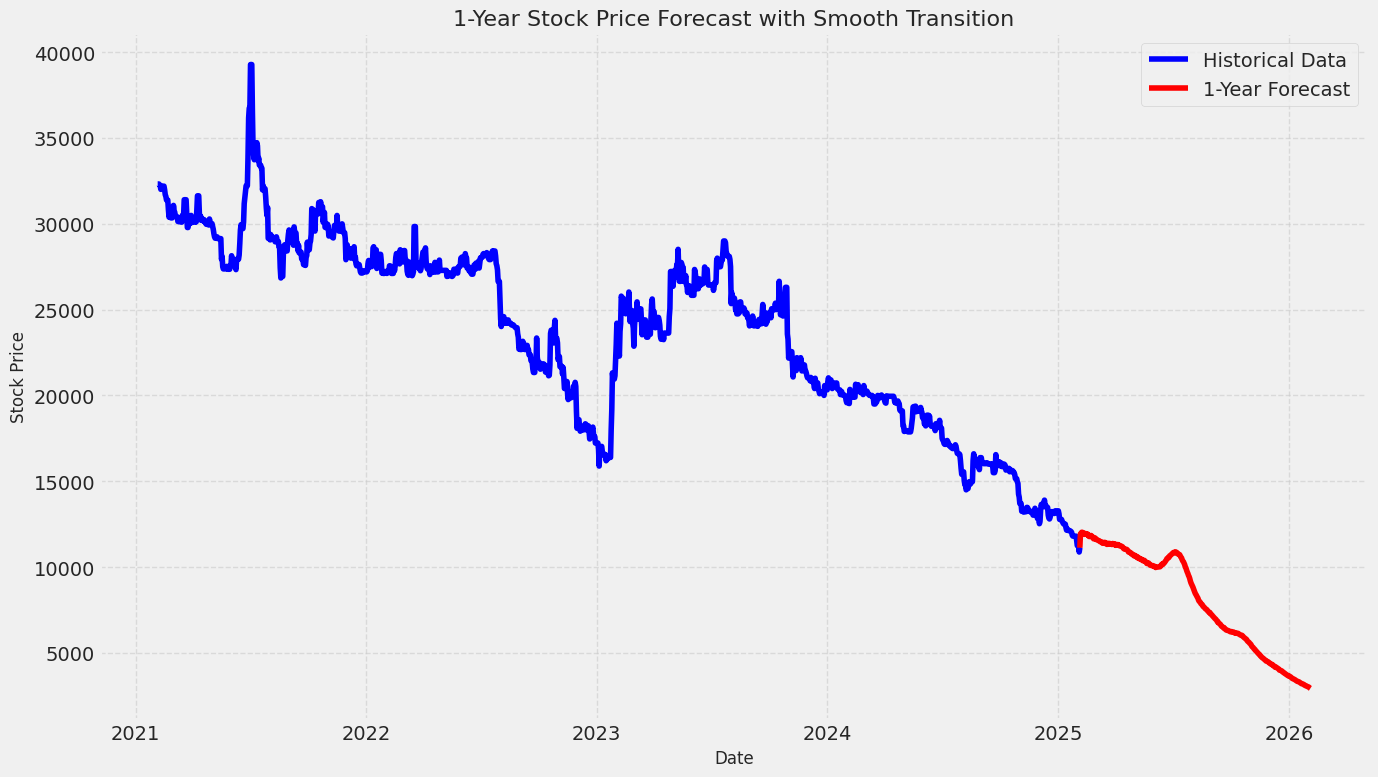

In [29]:
import matplotlib.pyplot as plt

# Find the last point of historical data
last_historical_date = df['ds'].max()
last_historical_value = df.loc[df['ds'] == last_historical_date, 'y'].values[0]

# Add the last historical point to the forecast for smooth transition
one_year_forecast = forecast[forecast['ds'] > last_historical_date]
smooth_forecast = pd.concat([
    pd.DataFrame({'ds': [last_historical_date], 'yhat': [last_historical_value]}),
    one_year_forecast[['ds', 'yhat']]
])

# Visualization: Historical and Forecasted Data
plt.figure(figsize=(14, 8))

# Plot historical data
plt.plot(df['ds'], df['y'], label='Historical Data', color='blue')

# Plot 1-year forecast with a smooth transition
plt.plot(smooth_forecast['ds'], smooth_forecast['yhat'], label='1-Year Forecast', color='red')

# # Add confidence intervals for the forecast
# plt.fill_between(
#     one_year_forecast['ds'],
#     one_year_forecast['yhat_lower'],
#     one_year_forecast['yhat_upper'],
#     color='pink', alpha=0.3, label='Uncertainty Interval'
# )

# Add title, labels, and legend
plt.title('1-Year Stock Price Forecast with Smooth Transition', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Insight:
1. Historical Data (2021 - 2024)

* GGRM stock has been in a long-term decline since mid-2022.
* Price has fallen significantly, showing no strong recovery signs in the recent past.

2. Prophet’s 1-Year Forecast (2025 - 2026)

* The forecast (red line) continues the downward trajectory.
* No trend reversal is detected, reinforcing the bearish sentiment.

Comparison with Previous LSTM Forecast
* Unlike the LSTM model, which unexpectedly predicted an upward spike, Prophet aligns more closely with the ongoing bearish trend.
* Prophet is less prone to overfitting short-term fluctuations, making it more reliable for long-term forecasting.

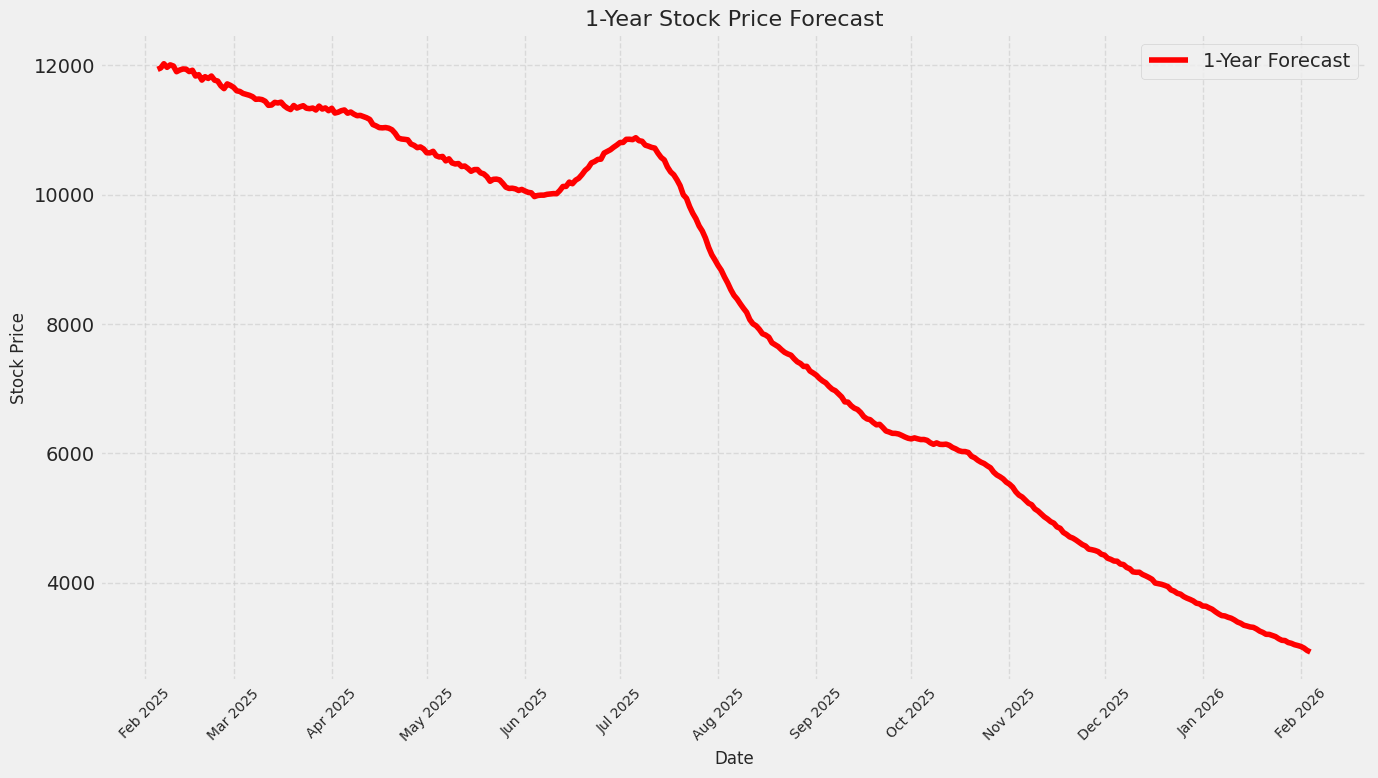

In [30]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Visualization of 1-Year Ahead Prediction with Monthly X-Ticks
plt.figure(figsize=(14, 8))

# Plot 1-year forecast
plt.plot(one_year_forecast['ds'], one_year_forecast['yhat'], label='1-Year Forecast', color='red')

# Add title and labels
plt.title('1-Year Stock Price Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)

# Add x-ticks for every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks: every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as "Month Year"
plt.xticks(rotation=45, fontsize=10)

# Add legend and grid
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()

In [31]:
forecast[['ds', 'yhat']].tail(10)

,ds,yhat
1816,2026-01-26,3110.606767
1817,2026-01-27,3106.163001
1818,2026-01-28,3075.919778
1819,2026-01-29,3063.681233
1820,2026-01-30,3042.266977
1821,2026-01-31,3029.890431
1822,2026-02-01,3015.183202
1823,2026-02-02,2989.863852
1824,2026-02-03,2952.902507
1825,2026-02-04,2929.269750


`Insight`

1. Added MAPE calculation for comprehensive error evaluation

2. Enhanced parameter grid with:

* Changepoint range adjustment

* Custom yearly seasonality with Fourier order tuning

* More granular parameter options

* Implemented proper future forecasting with:

* Full dataset training for final model

* 365-day forecast period

* Synthetic regressor generation (replace with real data in practice)

## **Model Comparison: Prophet vs. LSTM**

**Prophet**  
- Developed by Facebook/Meta to forecast user growth by demographics.  
- Handles seasonality effectively.  
- Limitations: Requires sufficient historical data for accuracy.

**LSTM (Long Short-Term Memory)**  
- Effective for sequential data and time-series forecasting.  
- Handles long-term dependencies.  
- Limitations: High computational cost and slow training times.

---

## **Forecasting Accuracy**

**LSTM Model Performance:**  
- **MAPE:** 19.5%  
- **MAE:** 3,106.18  

**Prophet Model Performance:**  
- **MAPE:** 5.5%  
- **MAE:** 833.37  

---

## **Insights and Interpretation**

1. **Downtrend:** GGRM stock prices have been consistently declining, and the model expects this trend to continue for the next year.  
2. **Seasonality:** Prices tend to be higher in the early months and lower towards the end of the year.

---

## **Conclusion**

1. **Long-Term Downtrend:** Both historical trends and the forecast model indicate a continued decline in GGRM stock prices.  
2. **Seasonality:** Prices are expected to be higher in Q1 and lower by year-end, suggesting potential for short-term trading strategies.  
3. **Bearish Outlook:** Unless there is a fundamental change, the stock is likely to continue its decline through 2025-2026.

---

## **Recommendations**

1. **Short GGRM for Long-Term Gains:**  
   - **Entry Point:** After the seasonal peak in Q1.  
   - **Exit Point:** Hold through the year-end dip, and potentially extend into 2025-2026 if the downtrend persists.

2. **Monitor Fundamental Changes:**  
   - Be vigilant for catalysts that may reverse the downtrend.  
   - Consider hedging volatility with put options if holding other investments in the same sector.

---

## **Thank You**  
Clove Investment Indonesia